In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

from skopt import gp_minimize
from skopt.space import Integer, Real

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_cdv


In [7]:
from tools.misc_tools import mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories, plot_reconstructed_data, plot_latent_states, return_hilbert_x0 
from tools.ae_v2 import Autoencoder
from tools.hyper_param import trainAE_and_return_testError

In [8]:
strategy = None

In [9]:
# setting seed for PRNGs
prng_seed = 42
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-07-31 07:55:25.339947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 07:55:25.401924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 07:55:25.402230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 07:55:25.403777: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *


# loading data directory
data_dir_idx = '004'

# making ae save directory
dir_name_ae_nsb = os.getcwd() + dir_sep + 'saved_ae_noiseSearchBayes'
if not os.path.isdir(dir_name_ae_nsb):
    os.makedirs(dir_name_ae_nsb)

counter = 0
while True:
    dir_check = 'nsb_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_ae_nsb + dir_sep + dir_check):
        counter += 1
    else:
        break
        
dir_name_ae_nsb = dir_name_ae_nsb + dir_sep + dir_check
os.makedirs(dir_name_ae_nsb)
dir_name_aensb_plots = dir_name_ae_nsb+dir_sep+'plots'
os.makedirs(dir_name_aensb_plots)

print('dir_name_ae_nsb:', dir_name_ae_nsb)
# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_ae_nsb: /home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae_noiseSearchBayes/nsb_001
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.027086916024239262, lyapunov time : 36.91819381713867s


In [14]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [15]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[     0 500001]


In [16]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [17]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [18]:
all_data = all_data[0:new_bia[-1]]

In [19]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [20]:
# dealing with normalizing the data before feeding into autoencoder

# normalize data before feeding into autoencoder?
normalizeforae_flag = True
normalization_type = 'stddev' # could be 'stddev' or 'minmax'
stddev_multiplier = 3
stddev_multiplier_pm = 1
num_params = params_mat.shape[1]

ae_data_with_params = False # whether to feed in the parameters to the AE along with the data?

og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

if ae_data_with_params == False:
    stddev_multiplier_pm = None
if normalizeforae_flag == False:
    stddev_multiplier = None

if ae_data_with_params == True and alldata_withparams_flag == False:
    new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
    new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
    del(all_data)
    all_data = new_all_data
    prev_idx = 0
    for i in range(boundary_idx_arr.shape[0]):
        all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
        prev_idx = boundary_idx_arr[i]

normalization_constant_arr_aedata = None
if normalizeforae_flag == True:
    normalization_constant_arr_aedata = np.empty(shape=(2, all_data.shape[1]), dtype=FTYPE)
    if normalization_type == 'stddev':
        sample_mean = np.mean(all_data, axis=0)
        sample_std = np.std(all_data, axis=0)
        normalization_constant_arr_aedata[0, :] = sample_mean
        normalization_constant_arr_aedata[1, 0:og_vars] = stddev_multiplier*sample_std[0:og_vars]
        if ae_data_with_params == True:
            normalization_constant_arr_aedata[1, og_vars:] = stddev_multiplier_pm*sample_std[og_vars:]
        zero_idx = np.where(normalization_constant_arr_aedata[1] == 0.0)[0]
        if len(zero_idx) > 0:
            normalization_constant_arr_aedata[1, zero_idx] = 1.0
    elif normalization_type == 'minmax':
        for i in range(all_data.shape[1]):
            sample_min = np.min(all_data[:, i])
            sample_max = np.max(all_data[:, i])
            if sample_max - sample_min == 0:
                sample_min = sample_min - 0.5
                sample_max = sample_min + 1
            normalization_constant_arr_aedata[0, i] = sample_min
            normalization_constant_arr_aedata[1, i] = sample_max - sample_min
    # if ae_data_with_params == True:
    #     normalization_constant_arr_aedata[0, og_vars:] = 0.0
    #     normalization_constant_arr_aedata[1, og_vars:] = 1.0
    for i in range(all_data.shape[1]):
        all_data[:, i] -= normalization_constant_arr_aedata[0, i]
        all_data[:, i] /= normalization_constant_arr_aedata[1, i]

# saving sim data
ae_data = {
    'data_dir_idx':data_dir_idx,
    'normalizeforae_flag':normalizeforae_flag,
    'normalization_constant_arr_aedata':normalization_constant_arr_aedata,
    'normalization_type':normalization_type,
    'stddev_multiplier':stddev_multiplier,
    'stddev_multiplier_pm':stddev_multiplier_pm,
    'ae_data_with_params':ae_data_with_params,
    'module':Autoencoder.__module__,
}
with open(dir_name_ae_nsb+dir_sep+'ae_data.txt', 'w') as f:
    f.write(str(ae_data))
np.savez(
    dir_name_ae_nsb+dir_sep+'normalization_data',
    normalization_constant_arr_aedata=[normalization_constant_arr_aedata],
)
            
time_stddev = np.std(all_data, axis=0)
if ae_data_with_params == False:
    all_data = all_data[:, 0:og_vars]
    time_stddev = time_stddev[0:og_vars]
else:
    time_stddev[og_vars:] = 1.0

In [21]:
normalization_constant_arr_aedata

array([[ 0.8598464 ,  0.20818995, -0.15084821, -0.4832867 , -0.19962065,
         0.18153833],
       [ 0.18234183,  0.22417355,  0.37001276,  0.33698028,  0.34491393,
         0.42713565]], dtype=float32)

# Autoencoder

In [22]:
# setting up training params
learning_rate_list = [1e-3, 1e-4]#, 1e-5]
epochs = 100
patience = 10  # parameter for early stopping
min_delta = 1e-6  # parameter for early stopping
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split
batch_size = 2**6
dt_ae = 0.5

# stddev = fRMS*timeMeanofSpaceRMS
contractive_lmda = 0.0
use_weights_post_dense = True
dropout_rate = 0.0


# saving training params
training_specific_params = {
    'learning_rate_list':learning_rate_list,
    'epochs':epochs,
    'patience':patience,
    'min_delta':min_delta,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size,
    'contractive_lmda':contractive_lmda,
    'dropout_rate':dropout_rate,
    'dt_ae':dt_ae
}

with open(dir_name_ae_nsb+dir_sep+'training_specific_params.txt', 'w') as f:
    f.write(str(training_specific_params))

In [23]:
all_data = all_data[0:370001]
boundary_idx_arr[0] = 370001

In [24]:
skip_factor = int(dt_ae/delta_t)

for i in range(len(boundary_idx_arr)-1, -1, -1):
    end_idx = boundary_idx_arr[i]
    if i == 0:
        begin_idx = 0
    else:
        begin_idx = boundary_idx_arr[i-1]

    num_elems_pre_indexing = end_idx - begin_idx
    num_elems_post_indexing = 1 + num_elems_pre_indexing//skip_factor

    boundary_idx_arr[i:] -= num_elems_pre_indexing-num_elems_post_indexing

    all_data[begin_idx:begin_idx+num_elems_post_indexing] = all_data[begin_idx:end_idx:skip_factor]
    all_data[begin_idx+num_elems_post_indexing:begin_idx+(boundary_idx_arr[-1]-boundary_idx_arr[i])] = all_data[end_idx:boundary_idx_arr[-1]+num_elems_post_indexing]

all_data = all_data[0:boundary_idx_arr[-1]]

In [25]:
boundary_idx_arr

array([74001])

In [26]:
all_data.shape

(74001, 6)

In [27]:
cum_samples = boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train += int( np.round(train_split*num_samples) )
    num_val += int( np.round(val_split*num_samples) )
    begin_idx = boundary_idx_arr[i]

# defining shapes
training_shape = [num_train]
training_shape.extend(all_data.shape[1:])

val_shape = [num_val]
val_shape.extend(all_data.shape[1:])

testing_shape = [cum_samples-num_train-num_val]
testing_shape.extend(all_data.shape[1:])

# defining required arrays
training_data = np.empty(shape=training_shape)

val_data = np.empty(shape=val_shape)

testing_data = np.empty(shape=testing_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train = int( np.round(train_split*num_samples) )
    num_val = int( np.round(val_split*num_samples) )

    training_data[training_data_rolling_count:training_data_rolling_count+num_train] = all_data[begin_idx:begin_idx+num_train]
    training_data_rolling_count += num_train

    val_data[val_data_rolling_count:val_data_rolling_count+num_val] = all_data[begin_idx+num_train:begin_idx+num_train+num_val]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val
    testing_data[testing_data_rolling_count:testing_data_rolling_count+num_test] = all_data[begin_idx+num_train+num_val:begin_idx+num_train+num_val+num_test]
    testing_data_rolling_count += num_test

    begin_idx = boundary_idx_arr[i]

# further shuffling
# idx = np.arange(0, training_data.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
np.random.shuffle(training_data)

# idx = np.arange(0, val_data.shape[0])
# np.random.shuffle(idx)
# val_data = val_data[idx]
np.random.shuffle(val_data)

# idx = np.arange(0, testing_data.shape[0])
# np.random.shuffle(idx)
# testing_data = testing_data[idx]
np.random.shuffle(testing_data)

In [28]:
#

In [29]:
# Initialize network
latent_space_dim = 5
# enc_layers = [128, 96, 64, 48, 32, 24, 26, 8, 4]
# enc_layers = [192, 96, 48, 24, 12, 6, 3]
# enc_layers = [96, 48, 24, 12, 6, 3]
# enc_layers = [128, 64, 32, 16, 8, 4]
# enc_layers = []
# enc_layers = [32, 16, 8, 4]
# for i in range(len(enc_layers)):
#     if latent_space_dim < enc_layers[-i-1]:
#         enc_layers = enc_layers[0:-i]
#         break
#     if i == len(enc_layers)-1:
#         enc_layers = []
# dec_layers = enc_layers[::-1]
enc_layers = [16, 8, 8]
dec_layers = [8, 8, 16]

enc_layer_act_func = 'elu' #'modified_relu_2'
enc_final_layer_act_func = 'tanh'
dec_layer_act_func = 'elu' #'modified_relu_2'
dec_final_layer_act_func = 'tanh'
reg_name = 'L2'

In [30]:
#

In [31]:
def optim_func(
        x, # [fRMS, lambda_reg]
        time_stddev=time_stddev,
        Autoencoder=Autoencoder,
        mytimecallback=mytimecallback,
        SaveLosses=SaveLosses,
        plot_losses=plot_losses,
        readAndReturnLossHistories=readAndReturnLossHistories,
        plot_reconstructed_data=plot_reconstructed_data,
        plot_latent_states=plot_latent_states,
        dir_name_ae=dir_name_ae_nsb,
        training_data=training_data,
        testing_data=testing_data,
        val_data=val_data,
        boundary_idx_arr=boundary_idx_arr,
        prng_seed=prng_seed,
        learning_rate_list=learning_rate_list,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        contractive_lmda=contractive_lmda,
        use_weights_post_dense=use_weights_post_dense,
        dropout_rate=dropout_rate,
        latent_space_dim=latent_space_dim,
        enc_layers=enc_layers,
        dec_layers=dec_layers,
        enc_layer_act_func=enc_layer_act_func, #'modified_relu_2'
        enc_final_layer_act_func=enc_final_layer_act_func,
        dec_layer_act_func=dec_layer_act_func, #'modified_relu_2'
        dec_final_layer_act_func=dec_final_layer_act_func,
        reg_name=reg_name,
    ):
    
    compute_time = time.time()
    
    test_mse = trainAE_and_return_testError(
        x, # [fRMS, lambda_reg]
        time_stddev,
        og_vars,
        Autoencoder,
        mytimecallback,
        SaveLosses,
        plot_losses,
        readAndReturnLossHistories,
        plot_reconstructed_data,
        plot_latent_states,
        dir_name_ae,
        training_data,
        testing_data,
        val_data,
        boundary_idx_arr,
        prng_seed=prng_seed,
        learning_rate_list=learning_rate_list,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        contractive_lmda=contractive_lmda,
        use_weights_post_dense=use_weights_post_dense,
        dropout_rate=dropout_rate,
        latent_space_dim=latent_space_dim,
        enc_layers=enc_layers,
        dec_layers=dec_layers,
        enc_layer_act_func=enc_layer_act_func, #'modified_relu_2'
        enc_final_layer_act_func=enc_final_layer_act_func,
        dec_layer_act_func=dec_layer_act_func, #'modified_relu_2'
        dec_final_layer_act_func=dec_final_layer_act_func,
        reg_name=reg_name
    )
    
    compute_time = time.time() - compute_time
    print('\ncompute_time : {:.0f}h {:.0f}m {:.0f}s\n'.format(
        float(compute_time // 3600),
        float((compute_time%3600)//60),
        float((compute_time%3600)%60),
    ))
    
    return test_mse

In [32]:
x_bounds = [
    [1e-4, 1e-1, "log-uniform", "Real"], # fRMS
    [1e-7, 1e-3, "log-uniform", "Real"], # lambda_reg
]

In [33]:
h_dims = len(x_bounds)
# num_points = 10*h_dims
num_points = 20

h_order = 0
while(True):
    if 2**(h_dims*h_order) >= num_points:
        break
    else:
        h_order += 1

print('h_dims : {} ; num_points : {} ; h_order : {}'.format(h_dims, num_points, h_order))

h_dims : 2 ; num_points : 20 ; h_order : 3


In [34]:
locs = return_hilbert_x0(num_points, h_dims, h_order)
# print(locs)
locs = np.array(locs, dtype=np.float64)
locs /= 2**h_order-1
# print(locs)

for i in range(h_dims):
    x1 = x_bounds[i][0]
    x2 = x_bounds[i][1]
    if x_bounds[i][2] == "log-uniform":
        x1 = np.log10(x1)
        x2 = np.log10(x2)
    spread = x2 - x1
    locs[:, i] *= spread
    locs[:, i] += x1
    if x_bounds[i][2] == "log-uniform":
        locs[:, i] = 10**(locs[:, i])

# print(locs)

In [35]:
dimensions = [
    eval(elem[3])(*elem[0:3]) for elem in x_bounds
]

In [36]:
print(locs)

x0 = [
    [elem2 for elem2 in elem1] for elem1 in locs
]

print(x0)

[[1.00000000e-04 1.00000000e-07]
 [2.68269580e-04 1.00000000e-07]
 [1.93069773e-03 3.72759372e-07]
 [1.93069773e-03 1.38949549e-06]
 [2.68269580e-04 5.17947468e-06]
 [1.00000000e-04 1.93069773e-05]
 [1.00000000e-04 7.19685673e-05]
 [2.68269580e-04 1.00000000e-03]
 [7.19685673e-04 1.00000000e-03]
 [1.93069773e-03 7.19685673e-05]
 [5.17947468e-03 1.93069773e-05]
 [5.17947468e-03 7.19685673e-05]
 [1.38949549e-02 1.00000000e-03]
 [3.72759372e-02 1.00000000e-03]
 [1.00000000e-01 7.19685673e-05]
 [1.00000000e-01 5.17947468e-06]
 [3.72759372e-02 5.17947468e-06]
 [5.17947468e-03 1.38949549e-06]
 [5.17947468e-03 3.72759372e-07]
 [3.72759372e-02 1.00000000e-07]]
[[0.0001, 1e-07], [0.00026826957952797245, 1e-07], [0.0019306977288832496, 3.727593720314938e-07], [0.0019306977288832496, 1.389495494373136e-06], [0.00026826957952797245, 5.179474679231212e-06], [0.0001, 1.9306977288832496e-05], [0.0001, 7.196856730011529e-05], [0.00026826957952797245, 0.001], [0.0007196856730011522, 0.001], [0.00193069

In [37]:
acq_func = "EI"
n_initial_points = 0
n_calls = n_initial_points + len(x0) + 10

In [38]:
optim_dict = {
    'fRMS_bounds':x_bounds[0],
    'lambda_reg_bounds':x_bounds[1],
    'n_calls':n_calls,
    'acq_func':acq_func,
    'n_initial_points':n_initial_points,
    'random_state':prng_seed,
}
with open(dir_name_ae_nsb + '/optim_params.txt', 'w') as f:
    f.write(str(optim_dict))

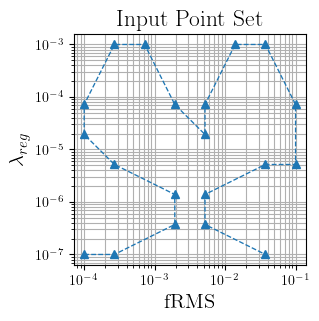

In [39]:
plt.loglog(
    locs[:, 0],
    locs[:, 1],
    '^',
    linestyle='--',
    linewidth=0.95
)
plt.grid(True, which='both')

plt.xlabel(r'fRMS', fontsize=15)
plt.ylabel(r'$\lambda_{reg}$', fontsize=15)
plt.title(r'Input Point Set', fontsize=17)

plt.gcf().set_size_inches(3,3)

plt.savefig(dir_name_aensb_plots+'/input_point_set.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [40]:
res = gp_minimize(
    optim_func,
    dimensions,
    x0=x0,
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    random_state=prng_seed,
    acq_func=acq_func,
)



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/100
926/926 [==============================] - 7s 6ms/step - loss: 0.0113 - mse: 0.0113 - NMSE: 0.1019 - real_MSE: 0.0113 - params_MSE: nan - ls_jacobian_norm: 1.4468 - val_loss: 0.0022 - val_mse: 0.0022 - val_NMSE: 0.0196 - val_real_MSE: 0.0022 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/100
926/926 [==============================] - 5s 6ms/step - loss: 0.0013 - mse: 0.0013 - NMSE: 0.0118 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.3545 - val_loss: 0.0010 - val_mse: 9.9544e-04 - val_NMSE: 0.0090 - val_real_MSE: 9.9544e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/100
926/926 [==============================] - 5s 6ms/step - loss: 5.3459e-04 - mse: 5.2583e-04 - NMSE: 0.0047 - real_M

Epoch 16/100
926/926 [==============================] - 5s 6ms/step - loss: 6.3464e-05 - mse: 5.3882e-05 - NMSE: 4.8494e-04 - real_MSE: 5.3882e-05 - params_MSE: nan - ls_jacobian_norm: 1.4775 - val_loss: 9.6902e-04 - val_mse: 9.5943e-04 - val_NMSE: 0.0086 - val_real_MSE: 9.5943e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/100
926/926 [==============================] - 6s 6ms/step - loss: 6.5803e-05 - mse: 5.6225e-05 - NMSE: 5.0602e-04 - real_MSE: 5.6225e-05 - params_MSE: nan - ls_jacobian_norm: 1.4816 - val_loss: 7.9560e-05 - val_mse: 6.9966e-05 - val_NMSE: 6.2969e-04 - val_real_MSE: 6.9966e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/100
926/926 [==============================] - 5s 6ms/step - loss: 5.9126e-05 - mse: 4.9531e-05 - NMSE: 4.4578e-04 - real_MSE: 4.9531e-05 - params_MSE: nan - ls_jacobian_norm: 1.4841 - val_loss: 2.9168e-04 - val_mse: 2.8208e-04 - val_NMSE: 0.0025 - val_real_MSE: 2.8208e-04 - val_params_MSE: nan - val_ls_jacobian

926/926 [==============================] - 6s 7ms/step - loss: 4.3128e-05 - mse: 3.3447e-05 - NMSE: 3.0102e-04 - real_MSE: 3.3447e-05 - params_MSE: nan - ls_jacobian_norm: 1.4639 - val_loss: 1.1477e-04 - val_mse: 1.0509e-04 - val_NMSE: 9.4576e-04 - val_real_MSE: 1.0509e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/100
926/926 [==============================] - 6s 7ms/step - loss: 4.2230e-05 - mse: 3.2543e-05 - NMSE: 2.9289e-04 - real_MSE: 3.2543e-05 - params_MSE: nan - ls_jacobian_norm: 1.4605 - val_loss: 7.0199e-05 - val_mse: 6.0505e-05 - val_NMSE: 5.4454e-04 - val_real_MSE: 6.0505e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/100
926/926 [==============================] - 6s 7ms/step - loss: 4.0635e-05 - mse: 3.0941e-05 - NMSE: 2.7847e-04 - real_MSE: 3.0941e-05 - params_MSE: nan - ls_jacobian_norm: 1.4567 - val_loss: 1.1185e-04 - val_mse: 1.0215e-04 - val_NMSE: 9.1938e-04 - val_real_MSE: 1.0215e-04 - val_params_MSE: nan - val_ls_jacobian_norm

Epoch 7/100
926/926 [==============================] - 6s 7ms/step - loss: 3.3766e-05 - mse: 2.4054e-05 - NMSE: 2.1649e-04 - real_MSE: 2.4054e-05 - params_MSE: nan - ls_jacobian_norm: 1.4498 - val_loss: 3.4377e-05 - val_mse: 2.4663e-05 - val_NMSE: 2.2196e-04 - val_real_MSE: 2.4663e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/100
926/926 [==============================] - 7s 7ms/step - loss: 3.3564e-05 - mse: 2.3847e-05 - NMSE: 2.1463e-04 - real_MSE: 2.3847e-05 - params_MSE: nan - ls_jacobian_norm: 1.4471 - val_loss: 3.2825e-05 - val_mse: 2.3106e-05 - val_NMSE: 2.0795e-04 - val_real_MSE: 2.3106e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/100
926/926 [==============================] - 6s 7ms/step - loss: 3.3397e-05 - mse: 2.3675e-05 - NMSE: 2.1307e-04 - real_MSE: 2.3675e-05 - params_MSE: nan - ls_jacobian_norm: 1.4440 - val_loss: 3.8701e-05 - val_mse: 2.8976e-05 - val_NMSE: 2.6078e-04 - val_real_MSE: 2.8976e-05 - val_params_MSE: nan - val_ls_jac

917/926 [============================>.] - ETA: 0s - loss: 3.1584e-05 - mse: 2.1807e-05 - NMSE: 1.9627e-04 - real_MSE: 2.1807e-05 - params_MSE: nan - ls_jacobian_norm: 1.4120Restoring model weights from the end of the best epoch: 12.
 - tot_time: 0h 6m 14.0s
926/926 [==============================] - 7s 7ms/step - loss: 3.1589e-05 - mse: 2.1812e-05 - NMSE: 1.9631e-04 - real_MSE: 2.1812e-05 - params_MSE: nan - ls_jacobian_norm: 1.4117 - val_loss: 4.4334e-05 - val_mse: 3.4556e-05 - val_NMSE: 3.1100e-04 - val_real_MSE: 3.4556e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22: early stopping
232/232 [==============================] - 0s 2ms/step - loss: 3.1547e-05 - mse: 2.1809e-05 - NMSE: 1.9628e-04 - real_MSE: 2.1809e-05 - params_MSE: nan - ls_jacobian_norm: -1.0000

compute_time : 0h 6m 25s



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

---------------

Epoch 14/100
926/926 [==============================] - 7s 7ms/step - loss: 7.1084e-05 - mse: 6.1527e-05 - NMSE: 5.5374e-04 - real_MSE: 6.1527e-05 - params_MSE: nan - ls_jacobian_norm: 1.4714 - val_loss: 8.9598e-05 - val_mse: 8.0038e-05 - val_NMSE: 7.2034e-04 - val_real_MSE: 8.0038e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/100
926/926 [==============================] - 7s 7ms/step - loss: 6.6427e-05 - mse: 5.6859e-05 - NMSE: 5.1173e-04 - real_MSE: 5.6859e-05 - params_MSE: nan - ls_jacobian_norm: 1.4746 - val_loss: 9.0370e-05 - val_mse: 8.0794e-05 - val_NMSE: 7.2715e-04 - val_real_MSE: 8.0794e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/100
926/926 [==============================] - 7s 7ms/step - loss: 6.3450e-05 - mse: 5.3868e-05 - NMSE: 4.8481e-04 - real_MSE: 5.3868e-05 - params_MSE: nan - ls_jacobian_norm: 1.4775 - val_loss: 9.7374e-04 - val_mse: 9.6415e-04 - val_NMSE: 0.0087 - val_real_MSE: 9.6415e-04 - val_params_MSE: nan - val_ls_jaco

926/926 [==============================] - 7s 7ms/step - loss: 4.4369e-05 - mse: 3.4698e-05 - NMSE: 3.1229e-04 - real_MSE: 3.4698e-05 - params_MSE: nan - ls_jacobian_norm: 1.4699 - val_loss: 4.6950e-05 - val_mse: 3.7274e-05 - val_NMSE: 3.3546e-04 - val_real_MSE: 3.7274e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/100
926/926 [==============================] - 6s 7ms/step - loss: 4.2653e-05 - mse: 3.2973e-05 - NMSE: 2.9676e-04 - real_MSE: 3.2973e-05 - params_MSE: nan - ls_jacobian_norm: 1.4649 - val_loss: 1.6303e-04 - val_mse: 1.5334e-04 - val_NMSE: 0.0014 - val_real_MSE: 1.5334e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/100
926/926 [==============================] - 7s 8ms/step - loss: 4.3097e-05 - mse: 3.3416e-05 - NMSE: 3.0074e-04 - real_MSE: 3.3416e-05 - params_MSE: nan - ls_jacobian_norm: 1.4639 - val_loss: 1.1713e-04 - val_mse: 1.0744e-04 - val_NMSE: 9.6695e-04 - val_real_MSE: 1.0744e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1

Epoch 5/100
926/926 [==============================] - 7s 7ms/step - loss: 3.4106e-05 - mse: 2.4405e-05 - NMSE: 2.1964e-04 - real_MSE: 2.4405e-05 - params_MSE: nan - ls_jacobian_norm: 1.4560 - val_loss: 3.5255e-05 - val_mse: 2.5551e-05 - val_NMSE: 2.2996e-04 - val_real_MSE: 2.5551e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/100
926/926 [==============================] - 7s 7ms/step - loss: 3.3869e-05 - mse: 2.4163e-05 - NMSE: 2.1746e-04 - real_MSE: 2.4163e-05 - params_MSE: nan - ls_jacobian_norm: 1.4531 - val_loss: 3.3124e-05 - val_mse: 2.3414e-05 - val_NMSE: 2.1073e-04 - val_real_MSE: 2.3414e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/100
926/926 [==============================] - 7s 7ms/step - loss: 3.3772e-05 - mse: 2.4060e-05 - NMSE: 2.1654e-04 - real_MSE: 2.4060e-05 - params_MSE: nan - ls_jacobian_norm: 1.4498 - val_loss: 3.4396e-05 - val_mse: 2.4682e-05 - val_NMSE: 2.2214e-04 - val_real_MSE: 2.4682e-05 - val_params_MSE: nan - val_ls_jac

926/926 [==============================] - 7s 7ms/step - loss: 3.1966e-05 - mse: 2.2197e-05 - NMSE: 1.9977e-04 - real_MSE: 2.2197e-05 - params_MSE: nan - ls_jacobian_norm: 1.4165 - val_loss: 3.2613e-05 - val_mse: 2.2843e-05 - val_NMSE: 2.0558e-04 - val_real_MSE: 2.2843e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/100
926/926 [==============================] - 6s 7ms/step - loss: 3.1726e-05 - mse: 2.1953e-05 - NMSE: 1.9758e-04 - real_MSE: 2.1953e-05 - params_MSE: nan - ls_jacobian_norm: 1.4141 - val_loss: 3.0652e-05 - val_mse: 2.0878e-05 - val_NMSE: 1.8790e-04 - val_real_MSE: 2.0878e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/100
926/926 [==============================] - ETA: 0s - loss: 3.1594e-05 - mse: 2.1817e-05 - NMSE: 1.9635e-04 - real_MSE: 2.1817e-05 - params_MSE: nan - ls_jacobian_norm: 1.4118Restoring model weights from the end of the best epoch: 12.
 - tot_time: 0h 6m 52.2s
926/926 [==============================] - 7s 7ms/step - lo

Epoch 12/100
926/926 [==============================] - 7s 7ms/step - loss: 1.0371e-04 - mse: 6.8847e-05 - NMSE: 6.1962e-04 - real_MSE: 6.8847e-05 - params_MSE: nan - ls_jacobian_norm: 1.4727 - val_loss: 1.1243e-04 - val_mse: 7.7561e-05 - val_NMSE: 6.9805e-04 - val_real_MSE: 7.7561e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/100
926/926 [==============================] - 6s 7ms/step - loss: 9.9472e-05 - mse: 6.4602e-05 - NMSE: 5.8141e-04 - real_MSE: 6.4602e-05 - params_MSE: nan - ls_jacobian_norm: 1.4779 - val_loss: 2.5358e-04 - val_mse: 2.1870e-04 - val_NMSE: 0.0020 - val_real_MSE: 2.1870e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/100
926/926 [==============================] - 7s 7ms/step - loss: 9.6972e-05 - mse: 6.2122e-05 - NMSE: 5.5909e-04 - real_MSE: 6.2122e-05 - params_MSE: nan - ls_jacobian_norm: 1.4848 - val_loss: 1.1406e-04 - val_mse: 7.9237e-05 - val_NMSE: 7.1313e-04 - val_real_MSE: 7.9237e-05 - val_params_MSE: nan - val_ls_jaco

926/926 [==============================] - 7s 7ms/step - loss: 7.0996e-05 - mse: 3.6749e-05 - NMSE: 3.3074e-04 - real_MSE: 3.6749e-05 - params_MSE: nan - ls_jacobian_norm: 1.4978 - val_loss: 8.9840e-05 - val_mse: 5.5604e-05 - val_NMSE: 5.0044e-04 - val_real_MSE: 5.5604e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 28/100
926/926 [==============================] - 7s 7ms/step - loss: 7.0698e-05 - mse: 3.6497e-05 - NMSE: 3.2847e-04 - real_MSE: 3.6497e-05 - params_MSE: nan - ls_jacobian_norm: 1.4965 - val_loss: 1.0537e-04 - val_mse: 7.1201e-05 - val_NMSE: 6.4081e-04 - val_real_MSE: 7.1201e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/100
926/926 [==============================] - 6s 7ms/step - loss: 6.9819e-05 - mse: 3.5683e-05 - NMSE: 3.2115e-04 - real_MSE: 3.5683e-05 - params_MSE: nan - ls_jacobian_norm: 1.4955 - val_loss: 8.0371e-05 - val_mse: 4.6247e-05 - val_NMSE: 4.1622e-04 - val_real_MSE: 4.6247e-05 - val_params_MSE: nan - val_ls_jacobian_norm

926/926 [==============================] - 7s 7ms/step - loss: 6.3053e-05 - mse: 2.9594e-05 - NMSE: 2.6634e-04 - real_MSE: 2.9594e-05 - params_MSE: nan - ls_jacobian_norm: 1.4728 - val_loss: 1.0644e-04 - val_mse: 7.3014e-05 - val_NMSE: 6.5713e-04 - val_real_MSE: 7.3014e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 43/100
926/926 [==============================] - 7s 7ms/step - loss: 6.1051e-05 - mse: 2.7649e-05 - NMSE: 2.4884e-04 - real_MSE: 2.7649e-05 - params_MSE: nan - ls_jacobian_norm: 1.4723 - val_loss: 8.5868e-05 - val_mse: 5.2491e-05 - val_NMSE: 4.7242e-04 - val_real_MSE: 5.2491e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 44/100
926/926 [==============================] - 7s 7ms/step - loss: 5.9927e-05 - mse: 2.6566e-05 - NMSE: 2.3910e-04 - real_MSE: 2.6566e-05 - params_MSE: nan - ls_jacobian_norm: 1.4707 - val_loss: 1.2012e-04 - val_mse: 8.6786e-05 - val_NMSE: 7.8107e-04 - val_real_MSE: 8.6786e-05 - val_params_MSE: nan - val_ls_jacobian_norm

926/926 [==============================] - 6s 7ms/step - loss: 5.7247e-05 - mse: 2.4564e-05 - NMSE: 2.2108e-04 - real_MSE: 2.4564e-05 - params_MSE: nan - ls_jacobian_norm: 1.4634 - val_loss: 7.1179e-05 - val_mse: 3.8523e-05 - val_NMSE: 3.4670e-04 - val_real_MSE: 3.8523e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 58/100
926/926 [==============================] - 7s 7ms/step - loss: 5.5937e-05 - mse: 2.3302e-05 - NMSE: 2.0971e-04 - real_MSE: 2.3302e-05 - params_MSE: nan - ls_jacobian_norm: 1.4632 - val_loss: 8.3513e-05 - val_mse: 5.0905e-05 - val_NMSE: 4.5814e-04 - val_real_MSE: 5.0905e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 59/100
926/926 [==============================] - 7s 7ms/step - loss: 5.5860e-05 - mse: 2.3277e-05 - NMSE: 2.0949e-04 - real_MSE: 2.3277e-05 - params_MSE: nan - ls_jacobian_norm: 1.4622 - val_loss: 1.2740e-04 - val_mse: 9.4836e-05 - val_NMSE: 8.5352e-04 - val_real_MSE: 9.4836e-05 - val_params_MSE: nan - val_ls_jacobian_norm

Epoch 11: early stopping
232/232 [==============================] - 1s 3ms/step - loss: 5.0526e-05 - mse: 1.7504e-05 - NMSE: 1.5754e-04 - real_MSE: 1.7504e-05 - params_MSE: nan - ls_jacobian_norm: -1.0000

compute_time : 0h 7m 60s



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/100
926/926 [==============================] - 8s 7ms/step - loss: 0.0114 - mse: 0.0113 - NMSE: 0.1019 - real_MSE: 0.0113 - params_MSE: nan - ls_jacobian_norm: 1.4463 - val_loss: 0.0023 - val_mse: 0.0022 - val_NMSE: 0.0196 - val_real_MSE: 0.0022 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0014 - mse: 0.0013 - NMSE: 0.0119 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.3535 - val_loss: 0.0011 - val_mse: 0.0010

Epoch 15/100
926/926 [==============================] - 6s 7ms/step - loss: 1.7859e-04 - mse: 5.8943e-05 - NMSE: 5.3048e-04 - real_MSE: 5.8943e-05 - params_MSE: nan - ls_jacobian_norm: 1.5391 - val_loss: 2.2360e-04 - val_mse: 1.0439e-04 - val_NMSE: 9.3950e-04 - val_real_MSE: 1.0439e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/100
926/926 [==============================] - 6s 6ms/step - loss: 1.7519e-04 - mse: 5.6425e-05 - NMSE: 5.0782e-04 - real_MSE: 5.6425e-05 - params_MSE: nan - ls_jacobian_norm: 1.5465 - val_loss: 7.5594e-04 - val_mse: 6.3750e-04 - val_NMSE: 0.0057 - val_real_MSE: 6.3750e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/100
926/926 [==============================] - 6s 7ms/step - loss: 1.7510e-04 - mse: 5.7263e-05 - NMSE: 5.1537e-04 - real_MSE: 5.7263e-05 - params_MSE: nan - ls_jacobian_norm: 1.5540 - val_loss: 1.7900e-04 - val_mse: 6.1384e-05 - val_NMSE: 5.5246e-04 - val_real_MSE: 6.1384e-05 - val_params_MSE: nan - val_ls_jaco

926/926 [==============================] - 6s 7ms/step - loss: 1.4646e-04 - mse: 3.7529e-05 - NMSE: 3.3776e-04 - real_MSE: 3.7529e-05 - params_MSE: nan - ls_jacobian_norm: 1.5916 - val_loss: 3.5339e-04 - val_mse: 2.4465e-04 - val_NMSE: 0.0022 - val_real_MSE: 2.4465e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/100
926/926 [==============================] - 6s 7ms/step - loss: 1.4715e-04 - mse: 3.8763e-05 - NMSE: 3.4886e-04 - real_MSE: 3.8763e-05 - params_MSE: nan - ls_jacobian_norm: 1.5962 - val_loss: 2.0078e-04 - val_mse: 9.2558e-05 - val_NMSE: 8.3302e-04 - val_real_MSE: 9.2558e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/100
926/926 [==============================] - 6s 7ms/step - loss: 1.4429e-04 - mse: 3.6319e-05 - NMSE: 3.2687e-04 - real_MSE: 3.6319e-05 - params_MSE: nan - ls_jacobian_norm: 1.5976 - val_loss: 1.8467e-04 - val_mse: 7.6888e-05 - val_NMSE: 6.9199e-04 - val_real_MSE: 7.6888e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1

Epoch 11/100
926/926 [==============================] - 6s 7ms/step - loss: 1.4312e-04 - mse: 3.1819e-05 - NMSE: 2.8637e-04 - real_MSE: 3.1819e-05 - params_MSE: nan - ls_jacobian_norm: 1.5649 - val_loss: 1.4566e-04 - val_mse: 3.4411e-05 - val_NMSE: 3.0970e-04 - val_real_MSE: 3.4411e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/100
926/926 [==============================] - 6s 7ms/step - loss: 1.4293e-04 - mse: 3.1748e-05 - NMSE: 2.8573e-04 - real_MSE: 3.1748e-05 - params_MSE: nan - ls_jacobian_norm: 1.5632 - val_loss: 1.4354e-04 - val_mse: 3.2418e-05 - val_NMSE: 2.9176e-04 - val_real_MSE: 3.2418e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/100
926/926 [==============================] - 6s 7ms/step - loss: 1.4264e-04 - mse: 3.1553e-05 - NMSE: 2.8398e-04 - real_MSE: 3.1553e-05 - params_MSE: nan - ls_jacobian_norm: 1.5613 - val_loss: 1.4692e-04 - val_mse: 3.5889e-05 - val_NMSE: 3.2300e-04 - val_real_MSE: 3.5889e-05 - val_params_MSE: nan - val_ls_

926/926 [==============================] - 6s 7ms/step - loss: 1.3915e-04 - mse: 2.9329e-05 - NMSE: 2.6396e-04 - real_MSE: 2.9329e-05 - params_MSE: nan - ls_jacobian_norm: 1.5471 - val_loss: 1.3945e-04 - val_mse: 2.9686e-05 - val_NMSE: 2.6718e-04 - val_real_MSE: 2.9686e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 27/100
926/926 [==============================] - 6s 6ms/step - loss: 1.3881e-04 - mse: 2.9081e-05 - NMSE: 2.6173e-04 - real_MSE: 2.9081e-05 - params_MSE: nan - ls_jacobian_norm: 1.5456 - val_loss: 1.4052e-04 - val_mse: 3.0847e-05 - val_NMSE: 2.7763e-04 - val_real_MSE: 3.0847e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 28/100
926/926 [==============================] - 7s 7ms/step - loss: 1.3855e-04 - mse: 2.8914e-05 - NMSE: 2.6023e-04 - real_MSE: 2.8914e-05 - params_MSE: nan - ls_jacobian_norm: 1.5448 - val_loss: 1.3859e-04 - val_mse: 2.8998e-05 - val_NMSE: 2.6098e-04 - val_real_MSE: 2.8998e-05 - val_params_MSE: nan - val_ls_jacobian_norm

926/926 [==============================] - 7s 7ms/step - loss: 9.9561e-04 - mse: 5.5703e-04 - NMSE: 0.0050 - real_MSE: 5.5703e-04 - params_MSE: nan - ls_jacobian_norm: 1.3780 - val_loss: 9.0277e-04 - val_mse: 4.6161e-04 - val_NMSE: 0.0042 - val_real_MSE: 4.6161e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/100
926/926 [==============================] - 7s 7ms/step - loss: 7.6092e-04 - mse: 3.2143e-04 - NMSE: 0.0029 - real_MSE: 3.2143e-04 - params_MSE: nan - ls_jacobian_norm: 1.3982 - val_loss: 7.5265e-04 - val_mse: 3.1499e-04 - val_NMSE: 0.0028 - val_real_MSE: 3.1499e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/100
926/926 [==============================] - 6s 7ms/step - loss: 6.6212e-04 - mse: 2.2726e-04 - NMSE: 0.0020 - real_MSE: 2.2726e-04 - params_MSE: nan - ls_jacobian_norm: 1.4376 - val_loss: 6.5666e-04 - val_mse: 2.2468e-04 - val_NMSE: 0.0020 - val_real_MSE: 2.2468e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/100
926/

Epoch 19/100
926/926 [==============================] - 7s 7ms/step - loss: 4.1333e-04 - mse: 6.0901e-05 - NMSE: 5.4811e-04 - real_MSE: 6.0901e-05 - params_MSE: nan - ls_jacobian_norm: 1.7177 - val_loss: 5.7069e-04 - val_mse: 2.2004e-04 - val_NMSE: 0.0020 - val_real_MSE: 2.2004e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/100
926/926 [==============================] - 6s 7ms/step - loss: 4.0887e-04 - mse: 5.8948e-05 - NMSE: 5.3053e-04 - real_MSE: 5.8948e-05 - params_MSE: nan - ls_jacobian_norm: 1.7266 - val_loss: 4.3659e-04 - val_mse: 8.7450e-05 - val_NMSE: 7.8705e-04 - val_real_MSE: 8.7450e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/100
926/926 [==============================] - 7s 8ms/step - loss: 4.0450e-04 - mse: 5.6724e-05 - NMSE: 5.1051e-04 - real_MSE: 5.6724e-05 - params_MSE: nan - ls_jacobian_norm: 1.7327 - val_loss: 4.1553e-04 - val_mse: 6.8580e-05 - val_NMSE: 6.1722e-04 - val_real_MSE: 6.8580e-05 - val_params_MSE: nan - val_ls_jaco

926/926 [==============================] - 7s 7ms/step - loss: 3.8322e-04 - mse: 4.9155e-05 - NMSE: 4.4240e-04 - real_MSE: 4.9155e-05 - params_MSE: nan - ls_jacobian_norm: 1.8365 - val_loss: 4.0839e-04 - val_mse: 7.4758e-05 - val_NMSE: 6.7282e-04 - val_real_MSE: 7.4758e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 35/100
926/926 [==============================] - 7s 7ms/step - loss: 3.8122e-04 - mse: 4.7773e-05 - NMSE: 4.2995e-04 - real_MSE: 4.7773e-05 - params_MSE: nan - ls_jacobian_norm: 1.8427 - val_loss: 4.2207e-04 - val_mse: 8.8657e-05 - val_NMSE: 7.9791e-04 - val_real_MSE: 8.8657e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/100
926/926 [==============================] - 7s 7ms/step - loss: 3.8127e-04 - mse: 4.8194e-05 - NMSE: 4.3374e-04 - real_MSE: 4.8194e-05 - params_MSE: nan - ls_jacobian_norm: 1.8504 - val_loss: 4.5291e-04 - val_mse: 1.2008e-04 - val_NMSE: 0.0011 - val_real_MSE: 1.2008e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1

Epoch 12/100
926/926 [==============================] - 7s 7ms/step - loss: 3.7911e-04 - mse: 4.1718e-05 - NMSE: 3.7546e-04 - real_MSE: 4.1718e-05 - params_MSE: nan - ls_jacobian_norm: 1.7817 - val_loss: 3.8411e-04 - val_mse: 4.6853e-05 - val_NMSE: 4.2167e-04 - val_real_MSE: 4.6853e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/100
926/926 [==============================] - 7s 7ms/step - loss: 3.7882e-04 - mse: 4.1567e-05 - NMSE: 3.7411e-04 - real_MSE: 4.1567e-05 - params_MSE: nan - ls_jacobian_norm: 1.7810 - val_loss: 3.9046e-04 - val_mse: 5.3283e-05 - val_NMSE: 4.7955e-04 - val_real_MSE: 5.3283e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/100
926/926 [==============================] - 7s 7ms/step - loss: 3.7893e-04 - mse: 4.1758e-05 - NMSE: 3.7582e-04 - real_MSE: 4.1758e-05 - params_MSE: nan - ls_jacobian_norm: 1.7822 - val_loss: 3.8322e-04 - val_mse: 4.6223e-05 - val_NMSE: 4.1600e-04 - val_real_MSE: 4.6223e-05 - val_params_MSE: nan - val_ls_

926/926 [==============================] - 7s 7ms/step - loss: 3.7562e-04 - mse: 3.9984e-05 - NMSE: 3.5985e-04 - real_MSE: 3.9984e-05 - params_MSE: nan - ls_jacobian_norm: 1.7871 - val_loss: 3.8123e-04 - val_mse: 4.5641e-05 - val_NMSE: 4.1077e-04 - val_real_MSE: 4.5641e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 28/100
926/926 [==============================] - 7s 7ms/step - loss: 3.7545e-04 - mse: 3.9886e-05 - NMSE: 3.5897e-04 - real_MSE: 3.9886e-05 - params_MSE: nan - ls_jacobian_norm: 1.7880 - val_loss: 3.8069e-04 - val_mse: 4.5163e-05 - val_NMSE: 4.0647e-04 - val_real_MSE: 4.5163e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/100
926/926 [==============================] - 7s 7ms/step - loss: 3.7542e-04 - mse: 4.0016e-05 - NMSE: 3.6015e-04 - real_MSE: 4.0016e-05 - params_MSE: nan - ls_jacobian_norm: 1.7887 - val_loss: 3.8044e-04 - val_mse: 4.4999e-05 - val_NMSE: 4.0499e-04 - val_real_MSE: 4.4999e-05 - val_params_MSE: nan - val_ls_jacobian_norm

926/926 [==============================] - 6s 7ms/step - loss: 0.0016 - mse: 2.5885e-04 - NMSE: 0.0023 - real_MSE: 2.5885e-04 - params_MSE: nan - ls_jacobian_norm: 1.5009 - val_loss: 0.0016 - val_mse: 2.6793e-04 - val_NMSE: 0.0024 - val_real_MSE: 2.6793e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0015 - mse: 2.0529e-04 - NMSE: 0.0018 - real_MSE: 2.0529e-04 - params_MSE: nan - ls_jacobian_norm: 1.5962 - val_loss: 0.0015 - val_mse: 2.2683e-04 - val_NMSE: 0.0020 - val_real_MSE: 2.2683e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0014 - mse: 1.7377e-04 - NMSE: 0.0016 - real_MSE: 1.7377e-04 - params_MSE: nan - ls_jacobian_norm: 1.6788 - val_loss: 0.0015 - val_mse: 2.9326e-04 - val_NMSE: 0.0026 - val_real_MSE: 2.9326e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/100
926/926 [===================

Epoch 21/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0012 - mse: 1.1563e-04 - NMSE: 0.0010 - real_MSE: 1.1563e-04 - params_MSE: nan - ls_jacobian_norm: 1.8944 - val_loss: 0.0013 - val_mse: 1.5220e-04 - val_NMSE: 0.0014 - val_real_MSE: 1.5220e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0012 - mse: 1.1404e-04 - NMSE: 0.0010 - real_MSE: 1.1404e-04 - params_MSE: nan - ls_jacobian_norm: 1.9005 - val_loss: 0.0017 - val_mse: 5.9123e-04 - val_NMSE: 0.0053 - val_real_MSE: 5.9123e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0012 - mse: 1.1664e-04 - NMSE: 0.0010 - real_MSE: 1.1664e-04 - params_MSE: nan - ls_jacobian_norm: 1.9058 - val_loss: 0.0013 - val_mse: 1.6971e-04 - val_NMSE: 0.0015 - val_real_MSE: 1.6971e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24/100
926/926 [===

Epoch 37/100
926/926 [==============================] - 5s 6ms/step - loss: 0.0012 - mse: 1.0667e-04 - NMSE: 9.6000e-04 - real_MSE: 1.0667e-04 - params_MSE: nan - ls_jacobian_norm: 1.9402 - val_loss: 0.0014 - val_mse: 2.6895e-04 - val_NMSE: 0.0024 - val_real_MSE: 2.6895e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 38/100
926/926 [==============================] - 5s 5ms/step - loss: 0.0012 - mse: 1.0819e-04 - NMSE: 9.7371e-04 - real_MSE: 1.0819e-04 - params_MSE: nan - ls_jacobian_norm: 1.9387 - val_loss: 0.0013 - val_mse: 1.5599e-04 - val_NMSE: 0.0014 - val_real_MSE: 1.5599e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 39/100
926/926 [==============================] - 5s 5ms/step - loss: 0.0012 - mse: 1.0644e-04 - NMSE: 9.5792e-04 - real_MSE: 1.0644e-04 - params_MSE: nan - ls_jacobian_norm: 1.9406 - val_loss: 0.0013 - val_mse: 1.4366e-04 - val_NMSE: 0.0013 - val_real_MSE: 1.4366e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 40/100


Epoch 52: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0012 - mse: 9.3914e-05 - NMSE: 8.4522e-04 - real_MSE: 9.3914e-05 - params_MSE: nan - ls_jacobian_norm: 1.9401 - val_loss: 0.0012 - val_mse: 1.1761e-04 - val_NMSE: 0.0011 - val_real_MSE: 1.1761e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0012 - mse: 9.3471e-05 - NMSE: 8.4123e-04 - real_MSE: 9.3471e-05 - params_MSE: nan - ls_jacobian_norm: 1.9406 - val_loss: 0.0012 - val_mse: 1.1750e-04 - val_NMSE: 0.0011 - val_real_MSE: 1.1750e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/100
926/926 [==============================] - 7s 7ms/step - l

926/926 [==============================] - 8s 7ms/step - loss: 0.0168 - mse: 0.0115 - NMSE: 0.1039 - real_MSE: 0.0115 - params_MSE: nan - ls_jacobian_norm: 1.4247 - val_loss: 0.0075 - val_mse: 0.0024 - val_NMSE: 0.0215 - val_real_MSE: 0.0024 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0065 - mse: 0.0016 - NMSE: 0.0146 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 1.3163 - val_loss: 0.0061 - val_mse: 0.0015 - val_NMSE: 0.0135 - val_real_MSE: 0.0015 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/100
926/926 [==============================] - 7s 8ms/step - loss: 0.0055 - mse: 0.0011 - NMSE: 0.0103 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 1.3583 - val_loss: 0.0052 - val_mse: 0.0011 - val_NMSE: 0.0102 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0049 - mse:

926/926 [==============================] - 7s 7ms/step - loss: 0.0041 - mse: 6.0030e-04 - NMSE: 0.0054 - real_MSE: 6.0030e-04 - params_MSE: nan - ls_jacobian_norm: 1.6279 - val_loss: 0.0041 - val_mse: 6.4661e-04 - val_NMSE: 0.0058 - val_real_MSE: 6.4661e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/100
926/926 [==============================] - 7s 8ms/step - loss: 0.0041 - mse: 5.8798e-04 - NMSE: 0.0053 - real_MSE: 5.8798e-04 - params_MSE: nan - ls_jacobian_norm: 1.6409 - val_loss: 0.0043 - val_mse: 7.7657e-04 - val_NMSE: 0.0070 - val_real_MSE: 7.7657e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0041 - mse: 5.8822e-04 - NMSE: 0.0053 - real_MSE: 5.8822e-04 - params_MSE: nan - ls_jacobian_norm: 1.6474 - val_loss: 0.0042 - val_mse: 6.8644e-04 - val_NMSE: 0.0062 - val_real_MSE: 6.8644e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/100
926/926 [================

Epoch 33/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 5.4683e-04 - NMSE: 0.0049 - real_MSE: 5.4683e-04 - params_MSE: nan - ls_jacobian_norm: 1.7212 - val_loss: 0.0041 - val_mse: 6.3107e-04 - val_NMSE: 0.0057 - val_real_MSE: 6.3107e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 34/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 5.4603e-04 - NMSE: 0.0049 - real_MSE: 5.4603e-04 - params_MSE: nan - ls_jacobian_norm: 1.7232 - val_loss: 0.0043 - val_mse: 7.8193e-04 - val_NMSE: 0.0070 - val_real_MSE: 7.8193e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 35/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 5.4520e-04 - NMSE: 0.0049 - real_MSE: 5.4520e-04 - params_MSE: nan - ls_jacobian_norm: 1.7307 - val_loss: 0.0041 - val_mse: 6.2088e-04 - val_NMSE: 0.0056 - val_real_MSE: 6.2088e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/100
926/926 [===

Epoch 49/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 5.2694e-04 - NMSE: 0.0047 - real_MSE: 5.2694e-04 - params_MSE: nan - ls_jacobian_norm: 1.7611 - val_loss: 0.0041 - val_mse: 6.0852e-04 - val_NMSE: 0.0055 - val_real_MSE: 6.0852e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 50/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 5.2953e-04 - NMSE: 0.0048 - real_MSE: 5.2953e-04 - params_MSE: nan - ls_jacobian_norm: 1.7621 - val_loss: 0.0041 - val_mse: 6.4740e-04 - val_NMSE: 0.0058 - val_real_MSE: 6.4740e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 51/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 5.2819e-04 - NMSE: 0.0048 - real_MSE: 5.2819e-04 - params_MSE: nan - ls_jacobian_norm: 1.7622 - val_loss: 0.0042 - val_mse: 7.0161e-04 - val_NMSE: 0.0063 - val_real_MSE: 7.0161e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 52/100
926/926 [===

Epoch 65/100
926/926 [==============================] - 7s 8ms/step - loss: 0.0040 - mse: 5.1812e-04 - NMSE: 0.0047 - real_MSE: 5.1812e-04 - params_MSE: nan - ls_jacobian_norm: 1.7861 - val_loss: 0.0041 - val_mse: 5.9317e-04 - val_NMSE: 0.0053 - val_real_MSE: 5.9317e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 66/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 5.1731e-04 - NMSE: 0.0047 - real_MSE: 5.1731e-04 - params_MSE: nan - ls_jacobian_norm: 1.7864 - val_loss: 0.0041 - val_mse: 5.9910e-04 - val_NMSE: 0.0054 - val_real_MSE: 5.9910e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 67/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 5.1525e-04 - NMSE: 0.0046 - real_MSE: 5.1525e-04 - params_MSE: nan - ls_jacobian_norm: 1.7892 - val_loss: 0.0044 - val_mse: 9.3141e-04 - val_NMSE: 0.0084 - val_real_MSE: 9.3141e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 68/100
926/926 [===

926/926 [==============================] - 6s 7ms/step - loss: 0.0040 - mse: 4.9295e-04 - NMSE: 0.0044 - real_MSE: 4.9295e-04 - params_MSE: nan - ls_jacobian_norm: 1.7868 - val_loss: 0.0041 - val_mse: 5.6006e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.6006e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 4.9215e-04 - NMSE: 0.0044 - real_MSE: 4.9215e-04 - params_MSE: nan - ls_jacobian_norm: 1.7870 - val_loss: 0.0041 - val_mse: 5.5383e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.5383e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 4.9153e-04 - NMSE: 0.0044 - real_MSE: 4.9153e-04 - params_MSE: nan - ls_jacobian_norm: 1.7868 - val_loss: 0.0041 - val_mse: 5.5423e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.5423e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/100
926/926 [===================

Epoch 17/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0040 - mse: 4.8895e-04 - NMSE: 0.0044 - real_MSE: 4.8895e-04 - params_MSE: nan - ls_jacobian_norm: 1.7834 - val_loss: 0.0041 - val_mse: 5.4978e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.4978e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/100
926/926 [==============================] - 7s 8ms/step - loss: 0.0040 - mse: 4.8786e-04 - NMSE: 0.0044 - real_MSE: 4.8786e-04 - params_MSE: nan - ls_jacobian_norm: 1.7848 - val_loss: 0.0041 - val_mse: 5.6166e-04 - val_NMSE: 0.0051 - val_real_MSE: 5.6166e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 4.8794e-04 - NMSE: 0.0044 - real_MSE: 4.8794e-04 - params_MSE: nan - ls_jacobian_norm: 1.7849 - val_loss: 0.0041 - val_mse: 5.5841e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.5841e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/100
916/926 [===

Epoch 12/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0329 - mse: 0.0092 - NMSE: 0.0832 - real_MSE: 0.0092 - params_MSE: nan - ls_jacobian_norm: 1.0408 - val_loss: 0.0335 - val_mse: 0.0099 - val_NMSE: 0.0889 - val_real_MSE: 0.0099 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0329 - mse: 0.0091 - NMSE: 0.0816 - real_MSE: 0.0091 - params_MSE: nan - ls_jacobian_norm: 1.0445 - val_loss: 0.0340 - val_mse: 0.0100 - val_NMSE: 0.0896 - val_real_MSE: 0.0100 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0329 - mse: 0.0090 - NMSE: 0.0813 - real_MSE: 0.0090 - params_MSE: nan - ls_jacobian_norm: 1.0444 - val_loss: 0.0336 - val_mse: 0.0098 - val_NMSE: 0.0881 - val_real_MSE: 0.0098 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/100
926/926 [==============================] - 6s 7ms/step - los

Epoch 29/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0328 - mse: 0.0090 - NMSE: 0.0808 - real_MSE: 0.0090 - params_MSE: nan - ls_jacobian_norm: 1.0513 - val_loss: 0.0335 - val_mse: 0.0097 - val_NMSE: 0.0870 - val_real_MSE: 0.0097 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0328 - mse: 0.0090 - NMSE: 0.0807 - real_MSE: 0.0090 - params_MSE: nan - ls_jacobian_norm: 1.0510 - val_loss: 0.0339 - val_mse: 0.0099 - val_NMSE: 0.0893 - val_real_MSE: 0.0099 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0329 - mse: 0.0090 - NMSE: 0.0807 - real_MSE: 0.0090 - params_MSE: nan - ls_jacobian_norm: 1.0496 - val_loss: 0.0335 - val_mse: 0.0097 - val_NMSE: 0.0870 - val_real_MSE: 0.0097 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/100
926/926 [==============================] - 6s 7ms/step - los

Epoch 10/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0328 - mse: 0.0089 - NMSE: 0.0800 - real_MSE: 0.0089 - params_MSE: nan - ls_jacobian_norm: 1.0492 - val_loss: 0.0334 - val_mse: 0.0095 - val_NMSE: 0.0855 - val_real_MSE: 0.0095 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0328 - mse: 0.0089 - NMSE: 0.0800 - real_MSE: 0.0089 - params_MSE: nan - ls_jacobian_norm: 1.0480 - val_loss: 0.0335 - val_mse: 0.0096 - val_NMSE: 0.0863 - val_real_MSE: 0.0096 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/100
922/926 [============================>.] - ETA: 0s - loss: 0.0328 - mse: 0.0089 - NMSE: 0.0800 - real_MSE: 0.0089 - params_MSE: nan - ls_jacobian_norm: 1.0481Restoring model weights from the end of the best epoch: 2.
 - tot_time: 0h 5m 12.4s
926/926 [==============================] - 7s 7ms/step - loss: 0.0328 - mse: 0.0089 - NMSE: 0.0800 - real_MSE: 0.0089 - params_

Epoch 13/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0329 - mse: 0.0091 - NMSE: 0.0816 - real_MSE: 0.0091 - params_MSE: nan - ls_jacobian_norm: 1.0445 - val_loss: 0.0340 - val_mse: 0.0100 - val_NMSE: 0.0896 - val_real_MSE: 0.0100 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0329 - mse: 0.0090 - NMSE: 0.0813 - real_MSE: 0.0090 - params_MSE: nan - ls_jacobian_norm: 1.0444 - val_loss: 0.0336 - val_mse: 0.0098 - val_NMSE: 0.0881 - val_real_MSE: 0.0098 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/100
926/926 [==============================] - 7s 8ms/step - loss: 0.0329 - mse: 0.0090 - NMSE: 0.0809 - real_MSE: 0.0090 - params_MSE: nan - ls_jacobian_norm: 1.0462 - val_loss: 0.0335 - val_mse: 0.0096 - val_NMSE: 0.0864 - val_real_MSE: 0.0096 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/100
926/926 [==============================] - 7s 7ms/step - los

Epoch 30/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0328 - mse: 0.0090 - NMSE: 0.0807 - real_MSE: 0.0090 - params_MSE: nan - ls_jacobian_norm: 1.0510 - val_loss: 0.0339 - val_mse: 0.0099 - val_NMSE: 0.0893 - val_real_MSE: 0.0099 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0329 - mse: 0.0090 - NMSE: 0.0807 - real_MSE: 0.0090 - params_MSE: nan - ls_jacobian_norm: 1.0495 - val_loss: 0.0335 - val_mse: 0.0097 - val_NMSE: 0.0870 - val_real_MSE: 0.0097 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0328 - mse: 0.0090 - NMSE: 0.0807 - real_MSE: 0.0090 - params_MSE: nan - ls_jacobian_norm: 1.0511 - val_loss: 0.0335 - val_mse: 0.0096 - val_NMSE: 0.0865 - val_real_MSE: 0.0096 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/100
926/926 [==============================] - 7s 8ms/step - los

Epoch 11/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0328 - mse: 0.0089 - NMSE: 0.0800 - real_MSE: 0.0089 - params_MSE: nan - ls_jacobian_norm: 1.0480 - val_loss: 0.0335 - val_mse: 0.0096 - val_NMSE: 0.0863 - val_real_MSE: 0.0096 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/100
919/926 [============================>.] - ETA: 0s - loss: 0.0328 - mse: 0.0089 - NMSE: 0.0801 - real_MSE: 0.0089 - params_MSE: nan - ls_jacobian_norm: 1.0480Restoring model weights from the end of the best epoch: 2.
 - tot_time: 0h 5m 15.8s
926/926 [==============================] - 7s 7ms/step - loss: 0.0328 - mse: 0.0089 - NMSE: 0.0801 - real_MSE: 0.0089 - params_MSE: nan - ls_jacobian_norm: 1.0481 - val_loss: 0.0335 - val_mse: 0.0095 - val_NMSE: 0.0859 - val_real_MSE: 0.0095 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12: early stopping
232/232 [==============================] - 1s 3ms/step - loss: 0.0334 - mse: 0.0094 - NMSE: 0.0850 - real_MSE: 0.00

926/926 [==============================] - 7s 8ms/step - loss: 0.0041 - mse: 6.2247e-04 - NMSE: 0.0056 - real_MSE: 6.2247e-04 - params_MSE: nan - ls_jacobian_norm: 1.5840 - val_loss: 0.0048 - val_mse: 0.0013 - val_NMSE: 0.0116 - val_real_MSE: 0.0013 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0041 - mse: 6.2530e-04 - NMSE: 0.0056 - real_MSE: 6.2530e-04 - params_MSE: nan - ls_jacobian_norm: 1.6028 - val_loss: 0.0042 - val_mse: 6.9932e-04 - val_NMSE: 0.0063 - val_real_MSE: 6.9932e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0041 - mse: 6.0782e-04 - NMSE: 0.0055 - real_MSE: 6.0782e-04 - params_MSE: nan - ls_jacobian_norm: 1.6084 - val_loss: 0.0042 - val_mse: 7.0088e-04 - val_NMSE: 0.0063 - val_real_MSE: 7.0088e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/100
926/926 [========================

Epoch 29/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 5.5657e-04 - NMSE: 0.0050 - real_MSE: 5.5657e-04 - params_MSE: nan - ls_jacobian_norm: 1.7054 - val_loss: 0.0041 - val_mse: 6.1190e-04 - val_NMSE: 0.0055 - val_real_MSE: 6.1190e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0040 - mse: 5.5426e-04 - NMSE: 0.0050 - real_MSE: 5.5426e-04 - params_MSE: nan - ls_jacobian_norm: 1.7113 - val_loss: 0.0049 - val_mse: 0.0013 - val_NMSE: 0.0121 - val_real_MSE: 0.0013 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0041 - mse: 5.6031e-04 - NMSE: 0.0050 - real_MSE: 5.6031e-04 - params_MSE: nan - ls_jacobian_norm: 1.7198 - val_loss: 0.0042 - val_mse: 6.8764e-04 - val_NMSE: 0.0062 - val_real_MSE: 6.8764e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/100
926/926 [===========

Epoch 45/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 5.3226e-04 - NMSE: 0.0048 - real_MSE: 5.3226e-04 - params_MSE: nan - ls_jacobian_norm: 1.7543 - val_loss: 0.0041 - val_mse: 6.2076e-04 - val_NMSE: 0.0056 - val_real_MSE: 6.2076e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 46/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 5.3114e-04 - NMSE: 0.0048 - real_MSE: 5.3114e-04 - params_MSE: nan - ls_jacobian_norm: 1.7530 - val_loss: 0.0041 - val_mse: 5.9074e-04 - val_NMSE: 0.0053 - val_real_MSE: 5.9074e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 47/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 5.3072e-04 - NMSE: 0.0048 - real_MSE: 5.3072e-04 - params_MSE: nan - ls_jacobian_norm: 1.7578 - val_loss: 0.0041 - val_mse: 5.8985e-04 - val_NMSE: 0.0053 - val_real_MSE: 5.8985e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 48/100
926/926 [===

Epoch 61/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 5.2030e-04 - NMSE: 0.0047 - real_MSE: 5.2030e-04 - params_MSE: nan - ls_jacobian_norm: 1.7793 - val_loss: 0.0041 - val_mse: 5.7466e-04 - val_NMSE: 0.0052 - val_real_MSE: 5.7466e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 62/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 5.1976e-04 - NMSE: 0.0047 - real_MSE: 5.1976e-04 - params_MSE: nan - ls_jacobian_norm: 1.7813 - val_loss: 0.0041 - val_mse: 5.9770e-04 - val_NMSE: 0.0054 - val_real_MSE: 5.9770e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 63/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 5.2084e-04 - NMSE: 0.0047 - real_MSE: 5.2084e-04 - params_MSE: nan - ls_jacobian_norm: 1.7823 - val_loss: 0.0041 - val_mse: 5.8919e-04 - val_NMSE: 0.0053 - val_real_MSE: 5.8919e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 64/100
926/926 [===

Epoch 77/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 5.1087e-04 - NMSE: 0.0046 - real_MSE: 5.1087e-04 - params_MSE: nan - ls_jacobian_norm: 1.8006 - val_loss: 0.0041 - val_mse: 5.7461e-04 - val_NMSE: 0.0052 - val_real_MSE: 5.7461e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 78/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 5.0827e-04 - NMSE: 0.0046 - real_MSE: 5.0827e-04 - params_MSE: nan - ls_jacobian_norm: 1.8004 - val_loss: 0.0041 - val_mse: 5.7548e-04 - val_NMSE: 0.0052 - val_real_MSE: 5.7548e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 79/100
920/926 [============================>.] - ETA: 0s - loss: 0.0040 - mse: 5.0965e-04 - NMSE: 0.0046 - real_MSE: 5.0965e-04 - params_MSE: nan - ls_jacobian_norm: 1.8029Restoring model weights from the end of the best epoch: 69.
 - tot_time: 0h 8m 40.5s
926/926 [==============================] - 6s 7ms/step - loss: 0.0040 - mse: 5.0933e-0

926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 4.8939e-04 - NMSE: 0.0044 - real_MSE: 4.8939e-04 - params_MSE: nan - ls_jacobian_norm: 1.7835 - val_loss: 0.0041 - val_mse: 5.6083e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.6083e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0040 - mse: 4.8867e-04 - NMSE: 0.0044 - real_MSE: 4.8867e-04 - params_MSE: nan - ls_jacobian_norm: 1.7855 - val_loss: 0.0041 - val_mse: 5.6022e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.6022e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 4.8927e-04 - NMSE: 0.0044 - real_MSE: 4.8927e-04 - params_MSE: nan - ls_jacobian_norm: 1.7840 - val_loss: 0.0041 - val_mse: 5.5319e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.5319e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/100
926/926 [================

926/926 [==============================] - 6s 7ms/step - loss: 0.0014 - mse: 1.7640e-04 - NMSE: 0.0016 - real_MSE: 1.7640e-04 - params_MSE: nan - ls_jacobian_norm: 1.6779 - val_loss: 0.0015 - val_mse: 2.8876e-04 - val_NMSE: 0.0026 - val_real_MSE: 2.8876e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0014 - mse: 1.6050e-04 - NMSE: 0.0014 - real_MSE: 1.6050e-04 - params_MSE: nan - ls_jacobian_norm: 1.7216 - val_loss: 0.0014 - val_mse: 2.0868e-04 - val_NMSE: 0.0019 - val_real_MSE: 2.0868e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0013 - mse: 1.4935e-04 - NMSE: 0.0013 - real_MSE: 1.4935e-04 - params_MSE: nan - ls_jacobian_norm: 1.7440 - val_loss: 0.0016 - val_mse: 3.9929e-04 - val_NMSE: 0.0036 - val_real_MSE: 3.9929e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/100
926/926 [==================

Epoch 23/100
926/926 [==============================] - 7s 8ms/step - loss: 0.0012 - mse: 1.1913e-04 - NMSE: 0.0011 - real_MSE: 1.1913e-04 - params_MSE: nan - ls_jacobian_norm: 1.9040 - val_loss: 0.0013 - val_mse: 1.8373e-04 - val_NMSE: 0.0017 - val_real_MSE: 1.8373e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0012 - mse: 1.1575e-04 - NMSE: 0.0010 - real_MSE: 1.1575e-04 - params_MSE: nan - ls_jacobian_norm: 1.9058 - val_loss: 0.0013 - val_mse: 1.4757e-04 - val_NMSE: 0.0013 - val_real_MSE: 1.4757e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0012 - mse: 1.1481e-04 - NMSE: 0.0010 - real_MSE: 1.1481e-04 - params_MSE: nan - ls_jacobian_norm: 1.9098 - val_loss: 0.0013 - val_mse: 1.6583e-04 - val_NMSE: 0.0015 - val_real_MSE: 1.6583e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 26/100
926/926 [===

926/926 [==============================] - 6s 7ms/step - loss: 0.0012 - mse: 1.0225e-04 - NMSE: 9.2021e-04 - real_MSE: 1.0225e-04 - params_MSE: nan - ls_jacobian_norm: 1.9154 - val_loss: 0.0012 - val_mse: 1.2387e-04 - val_NMSE: 0.0011 - val_real_MSE: 1.2387e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0012 - mse: 1.0207e-04 - NMSE: 9.1863e-04 - real_MSE: 1.0207e-04 - params_MSE: nan - ls_jacobian_norm: 1.9131 - val_loss: 0.0012 - val_mse: 1.2196e-04 - val_NMSE: 0.0011 - val_real_MSE: 1.2196e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0012 - mse: 1.0199e-04 - NMSE: 9.1795e-04 - real_MSE: 1.0199e-04 - params_MSE: nan - ls_jacobian_norm: 1.9128 - val_loss: 0.0012 - val_mse: 1.2443e-04 - val_NMSE: 0.0011 - val_real_MSE: 1.2443e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/100
926/926 [=======

Epoch 3/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0055 - mse: 0.0011 - NMSE: 0.0103 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 1.3580 - val_loss: 0.0052 - val_mse: 0.0011 - val_NMSE: 0.0102 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0049 - mse: 9.6409e-04 - NMSE: 0.0087 - real_MSE: 9.6409e-04 - params_MSE: nan - ls_jacobian_norm: 1.4010 - val_loss: 0.0048 - val_mse: 0.0010 - val_NMSE: 0.0090 - val_real_MSE: 0.0010 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0046 - mse: 8.7456e-04 - NMSE: 0.0079 - real_MSE: 8.7456e-04 - params_MSE: nan - ls_jacobian_norm: 1.4196 - val_loss: 0.0046 - val_mse: 9.5842e-04 - val_NMSE: 0.0086 - val_real_MSE: 9.5842e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/100
926/926 [==============================]

Epoch 19/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0041 - mse: 5.9043e-04 - NMSE: 0.0053 - real_MSE: 5.9043e-04 - params_MSE: nan - ls_jacobian_norm: 1.6471 - val_loss: 0.0042 - val_mse: 6.8289e-04 - val_NMSE: 0.0061 - val_real_MSE: 6.8289e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0041 - mse: 5.8357e-04 - NMSE: 0.0053 - real_MSE: 5.8357e-04 - params_MSE: nan - ls_jacobian_norm: 1.6563 - val_loss: 0.0042 - val_mse: 6.6522e-04 - val_NMSE: 0.0060 - val_real_MSE: 6.6522e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0041 - mse: 5.8060e-04 - NMSE: 0.0052 - real_MSE: 5.8060e-04 - params_MSE: nan - ls_jacobian_norm: 1.6650 - val_loss: 0.0041 - val_mse: 6.3599e-04 - val_NMSE: 0.0057 - val_real_MSE: 6.3599e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/100
926/926 [===

Epoch 35/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0040 - mse: 5.4739e-04 - NMSE: 0.0049 - real_MSE: 5.4739e-04 - params_MSE: nan - ls_jacobian_norm: 1.7300 - val_loss: 0.0041 - val_mse: 6.2537e-04 - val_NMSE: 0.0056 - val_real_MSE: 6.2537e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 5.4233e-04 - NMSE: 0.0049 - real_MSE: 5.4233e-04 - params_MSE: nan - ls_jacobian_norm: 1.7286 - val_loss: 0.0041 - val_mse: 6.4411e-04 - val_NMSE: 0.0058 - val_real_MSE: 6.4411e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 37/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0040 - mse: 5.4204e-04 - NMSE: 0.0049 - real_MSE: 5.4204e-04 - params_MSE: nan - ls_jacobian_norm: 1.7331 - val_loss: 0.0044 - val_mse: 9.0884e-04 - val_NMSE: 0.0082 - val_real_MSE: 9.0884e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 38/100
926/926 [===

Epoch 51/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 5.3001e-04 - NMSE: 0.0048 - real_MSE: 5.3001e-04 - params_MSE: nan - ls_jacobian_norm: 1.7613 - val_loss: 0.0042 - val_mse: 7.1838e-04 - val_NMSE: 0.0065 - val_real_MSE: 7.1838e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 52/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 5.2993e-04 - NMSE: 0.0048 - real_MSE: 5.2993e-04 - params_MSE: nan - ls_jacobian_norm: 1.7662 - val_loss: 0.0041 - val_mse: 6.2619e-04 - val_NMSE: 0.0056 - val_real_MSE: 6.2619e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 53/100
926/926 [==============================] - 7s 8ms/step - loss: 0.0040 - mse: 5.3127e-04 - NMSE: 0.0048 - real_MSE: 5.3127e-04 - params_MSE: nan - ls_jacobian_norm: 1.7676 - val_loss: 0.0041 - val_mse: 6.0093e-04 - val_NMSE: 0.0054 - val_real_MSE: 6.0093e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 54/100
926/926 [===

Epoch 67/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 5.1751e-04 - NMSE: 0.0047 - real_MSE: 5.1751e-04 - params_MSE: nan - ls_jacobian_norm: 1.7886 - val_loss: 0.0044 - val_mse: 9.2883e-04 - val_NMSE: 0.0084 - val_real_MSE: 9.2883e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 68/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0040 - mse: 5.2680e-04 - NMSE: 0.0047 - real_MSE: 5.2680e-04 - params_MSE: nan - ls_jacobian_norm: 1.7885 - val_loss: 0.0041 - val_mse: 5.8351e-04 - val_NMSE: 0.0053 - val_real_MSE: 5.8351e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 69/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 5.1832e-04 - NMSE: 0.0047 - real_MSE: 5.1832e-04 - params_MSE: nan - ls_jacobian_norm: 1.7887 - val_loss: 0.0041 - val_mse: 5.5800e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.5800e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 70/100
926/926 [===

926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 4.9366e-04 - NMSE: 0.0044 - real_MSE: 4.9366e-04 - params_MSE: nan - ls_jacobian_norm: 1.7858 - val_loss: 0.0041 - val_mse: 5.5455e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.5455e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 4.9371e-04 - NMSE: 0.0044 - real_MSE: 4.9371e-04 - params_MSE: nan - ls_jacobian_norm: 1.7859 - val_loss: 0.0041 - val_mse: 5.5366e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.5366e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 4.9189e-04 - NMSE: 0.0044 - real_MSE: 4.9189e-04 - params_MSE: nan - ls_jacobian_norm: 1.7846 - val_loss: 0.0041 - val_mse: 5.5994e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.5994e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/100
926/926 [===================

Epoch 19/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0040 - mse: 4.9007e-04 - NMSE: 0.0044 - real_MSE: 4.9007e-04 - params_MSE: nan - ls_jacobian_norm: 1.7841 - val_loss: 0.0041 - val_mse: 5.5838e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.5838e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/100
926/926 [==============================] - ETA: 0s - loss: 0.0040 - mse: 4.9032e-04 - NMSE: 0.0044 - real_MSE: 4.9032e-04 - params_MSE: nan - ls_jacobian_norm: 1.7833Restoring model weights from the end of the best epoch: 10.
 - tot_time: 0h 10m 59.7s
926/926 [==============================] - 7s 7ms/step - loss: 0.0040 - mse: 4.9032e-04 - NMSE: 0.0044 - real_MSE: 4.9032e-04 - params_MSE: nan - ls_jacobian_norm: 1.7833 - val_loss: 0.0041 - val_mse: 5.5642e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.5642e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20: early stopping
232/232 [==============================] - 1s 2ms/step - loss: 0.0041 - m

Epoch 14/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0329 - mse: 0.0090 - NMSE: 0.0814 - real_MSE: 0.0090 - params_MSE: nan - ls_jacobian_norm: 1.0442 - val_loss: 0.0336 - val_mse: 0.0098 - val_NMSE: 0.0881 - val_real_MSE: 0.0098 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0329 - mse: 0.0090 - NMSE: 0.0810 - real_MSE: 0.0090 - params_MSE: nan - ls_jacobian_norm: 1.0460 - val_loss: 0.0335 - val_mse: 0.0096 - val_NMSE: 0.0864 - val_real_MSE: 0.0096 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0329 - mse: 0.0090 - NMSE: 0.0808 - real_MSE: 0.0090 - params_MSE: nan - ls_jacobian_norm: 1.0482 - val_loss: 0.0340 - val_mse: 0.0101 - val_NMSE: 0.0911 - val_real_MSE: 0.0101 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/100
926/926 [==============================] - 7s 8ms/step - los

Epoch 31/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0329 - mse: 0.0090 - NMSE: 0.0808 - real_MSE: 0.0090 - params_MSE: nan - ls_jacobian_norm: 1.0493 - val_loss: 0.0335 - val_mse: 0.0097 - val_NMSE: 0.0871 - val_real_MSE: 0.0097 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0328 - mse: 0.0090 - NMSE: 0.0808 - real_MSE: 0.0090 - params_MSE: nan - ls_jacobian_norm: 1.0511 - val_loss: 0.0335 - val_mse: 0.0096 - val_NMSE: 0.0865 - val_real_MSE: 0.0096 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0328 - mse: 0.0090 - NMSE: 0.0807 - real_MSE: 0.0090 - params_MSE: nan - ls_jacobian_norm: 1.0514 - val_loss: 0.0336 - val_mse: 0.0098 - val_NMSE: 0.0879 - val_real_MSE: 0.0098 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 34/100
926/926 [==============================] - 7s 8ms/step - los

Epoch 12/100
920/926 [============================>.] - ETA: 0s - loss: 0.0328 - mse: 0.0089 - NMSE: 0.0801 - real_MSE: 0.0089 - params_MSE: nan - ls_jacobian_norm: 1.0481Restoring model weights from the end of the best epoch: 2.
 - tot_time: 0h 5m 13.4s
926/926 [==============================] - 6s 7ms/step - loss: 0.0328 - mse: 0.0089 - NMSE: 0.0801 - real_MSE: 0.0089 - params_MSE: nan - ls_jacobian_norm: 1.0481 - val_loss: 0.0335 - val_mse: 0.0095 - val_NMSE: 0.0859 - val_real_MSE: 0.0095 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12: early stopping
232/232 [==============================] - 1s 3ms/step - loss: 0.0334 - mse: 0.0094 - NMSE: 0.0850 - real_MSE: 0.0094 - params_MSE: nan - ls_jacobian_norm: -1.0000

compute_time : 0h 5m 23s



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

-------------------------------------------------------------------

Epoch 15/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0329 - mse: 0.0090 - NMSE: 0.0814 - real_MSE: 0.0090 - params_MSE: nan - ls_jacobian_norm: 1.0453 - val_loss: 0.0335 - val_mse: 0.0096 - val_NMSE: 0.0865 - val_real_MSE: 0.0096 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0329 - mse: 0.0090 - NMSE: 0.0812 - real_MSE: 0.0090 - params_MSE: nan - ls_jacobian_norm: 1.0475 - val_loss: 0.0340 - val_mse: 0.0102 - val_NMSE: 0.0914 - val_real_MSE: 0.0102 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/100
926/926 [==============================] - 7s 8ms/step - loss: 0.0329 - mse: 0.0091 - NMSE: 0.0815 - real_MSE: 0.0091 - params_MSE: nan - ls_jacobian_norm: 1.0463 - val_loss: 0.0336 - val_mse: 0.0096 - val_NMSE: 0.0865 - val_real_MSE: 0.0096 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/100
926/926 [==============================] - 6s 7ms/step - los

Epoch 32/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0329 - mse: 0.0090 - NMSE: 0.0812 - real_MSE: 0.0090 - params_MSE: nan - ls_jacobian_norm: 1.0508 - val_loss: 0.0335 - val_mse: 0.0096 - val_NMSE: 0.0867 - val_real_MSE: 0.0096 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0329 - mse: 0.0090 - NMSE: 0.0811 - real_MSE: 0.0090 - params_MSE: nan - ls_jacobian_norm: 1.0509 - val_loss: 0.0336 - val_mse: 0.0098 - val_NMSE: 0.0880 - val_real_MSE: 0.0098 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 34/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0329 - mse: 0.0090 - NMSE: 0.0811 - real_MSE: 0.0090 - params_MSE: nan - ls_jacobian_norm: 1.0513 - val_loss: 0.0336 - val_mse: 0.0097 - val_NMSE: 0.0873 - val_real_MSE: 0.0097 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 35/100
919/926 [============================>.] - ETA: 0s - loss: 0

Epoch 12: early stopping
232/232 [==============================] - 1s 3ms/step - loss: 0.0334 - mse: 0.0095 - NMSE: 0.0851 - real_MSE: 0.0095 - params_MSE: nan - ls_jacobian_norm: -1.0000

compute_time : 0h 5m 29s



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/100
926/926 [==============================] - 9s 8ms/step - loss: 0.0173 - mse: 0.0120 - NMSE: 0.1084 - real_MSE: 0.0120 - params_MSE: nan - ls_jacobian_norm: 1.3888 - val_loss: 0.0077 - val_mse: 0.0026 - val_NMSE: 0.0234 - val_real_MSE: 0.0026 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0071 - mse: 0.0022 - NMSE: 0.0202 - real_MSE: 0.0022 - params_MSE: nan - ls_jacobian_norm: 1.2675 - val_loss: 0.0062 - val_mse: 0.0016 - val_NMSE: 0.0

Epoch 16/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0047 - mse: 0.0013 - NMSE: 0.0115 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.5181 - val_loss: 0.0044 - val_mse: 9.2365e-04 - val_NMSE: 0.0083 - val_real_MSE: 9.2365e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/100
926/926 [==============================] - 7s 8ms/step - loss: 0.0047 - mse: 0.0013 - NMSE: 0.0115 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.5261 - val_loss: 0.0043 - val_mse: 8.3793e-04 - val_NMSE: 0.0075 - val_real_MSE: 8.3793e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0047 - mse: 0.0013 - NMSE: 0.0115 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.5347 - val_loss: 0.0045 - val_mse: 0.0011 - val_NMSE: 0.0095 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/100
926/926 [==============================] - 7

Epoch 33/100
926/926 [==============================] - 7s 8ms/step - loss: 0.0047 - mse: 0.0012 - NMSE: 0.0111 - real_MSE: 0.0012 - params_MSE: nan - ls_jacobian_norm: 1.5929 - val_loss: 0.0042 - val_mse: 7.8138e-04 - val_NMSE: 0.0070 - val_real_MSE: 7.8138e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 34/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0047 - mse: 0.0012 - NMSE: 0.0111 - real_MSE: 0.0012 - params_MSE: nan - ls_jacobian_norm: 1.5926 - val_loss: 0.0045 - val_mse: 0.0010 - val_NMSE: 0.0092 - val_real_MSE: 0.0010 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 35/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0047 - mse: 0.0012 - NMSE: 0.0111 - real_MSE: 0.0012 - params_MSE: nan - ls_jacobian_norm: 1.6007 - val_loss: 0.0043 - val_mse: 8.5445e-04 - val_NMSE: 0.0077 - val_real_MSE: 8.5445e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/100
926/926 [==============================] - 7

Epoch 11/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0046 - mse: 0.0012 - NMSE: 0.0107 - real_MSE: 0.0012 - params_MSE: nan - ls_jacobian_norm: 1.5738 - val_loss: 0.0042 - val_mse: 7.3956e-04 - val_NMSE: 0.0067 - val_real_MSE: 7.3956e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0046 - mse: 0.0012 - NMSE: 0.0107 - real_MSE: 0.0012 - params_MSE: nan - ls_jacobian_norm: 1.5731 - val_loss: 0.0042 - val_mse: 7.3563e-04 - val_NMSE: 0.0066 - val_real_MSE: 7.3563e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0046 - mse: 0.0012 - NMSE: 0.0107 - real_MSE: 0.0012 - params_MSE: nan - ls_jacobian_norm: 1.5725 - val_loss: 0.0042 - val_mse: 7.4016e-04 - val_NMSE: 0.0067 - val_real_MSE: 7.4016e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/100
926/926 [===========================

232/232 [==============================] - 1s 2ms/step - loss: 0.0042 - mse: 7.2909e-04 - NMSE: 0.0066 - real_MSE: 7.2909e-04 - params_MSE: nan - ls_jacobian_norm: -1.0000

compute_time : 0h 7m 21s



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/100
926/926 [==============================] - 9s 7ms/step - loss: 0.0122 - mse: 0.0119 - NMSE: 0.1067 - real_MSE: 0.0119 - params_MSE: nan - ls_jacobian_norm: 1.4042 - val_loss: 0.0028 - val_mse: 0.0024 - val_NMSE: 0.0217 - val_real_MSE: 0.0024 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0024 - mse: 0.0020 - NMSE: 0.0178 - real_MSE: 0.0020 - params_MSE: nan - ls_jacobian_norm: 1.2843 - val_loss: 0.0016 - val_mse: 0.0012 - val_NMSE: 0.0104 - val_real_MS

926/926 [==============================] - 7s 7ms/step - loss: 0.0012 - mse: 7.6884e-04 - NMSE: 0.0069 - real_MSE: 7.6884e-04 - params_MSE: nan - ls_jacobian_norm: 1.6709 - val_loss: 6.1479e-04 - val_mse: 2.2644e-04 - val_NMSE: 0.0020 - val_real_MSE: 2.2644e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0012 - mse: 7.6363e-04 - NMSE: 0.0069 - real_MSE: 7.6363e-04 - params_MSE: nan - ls_jacobian_norm: 1.6934 - val_loss: 9.4271e-04 - val_mse: 5.5720e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.5720e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/100
926/926 [==============================] - 7s 8ms/step - loss: 0.0012 - mse: 7.7253e-04 - NMSE: 0.0070 - real_MSE: 7.7253e-04 - params_MSE: nan - ls_jacobian_norm: 1.7054 - val_loss: 6.3554e-04 - val_mse: 2.5250e-04 - val_NMSE: 0.0023 - val_real_MSE: 2.5250e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/100
926/926 [====

Epoch 30: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/100
926/926 [==============================] - 7s 8ms/step - loss: 0.0011 - mse: 7.0083e-04 - NMSE: 0.0063 - real_MSE: 7.0083e-04 - params_MSE: nan - ls_jacobian_norm: 1.7731 - val_loss: 5.3111e-04 - val_mse: 1.5393e-04 - val_NMSE: 0.0014 - val_real_MSE: 1.5393e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0011 - mse: 6.9967e-04 - NMSE: 0.0063 - real_MSE: 6.9967e-04 - params_MSE: nan - ls_jacobian_norm: 1.7710 - val_loss: 5.3266e-04 - val_mse: 1.5558e-04 - val_NMSE: 0.0014 - val_real_MSE: 1.5558e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/100
926/926 [==============================] - 7s 7ms/step - l

926/926 [==============================] - 7s 7ms/step - loss: 0.0011 - mse: 6.9219e-04 - NMSE: 0.0062 - real_MSE: 6.9219e-04 - params_MSE: nan - ls_jacobian_norm: 1.7677 - val_loss: 5.3194e-04 - val_mse: 1.5652e-04 - val_NMSE: 0.0014 - val_real_MSE: 1.5652e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/100
926/926 [==============================] - 7s 8ms/step - loss: 0.0011 - mse: 6.9092e-04 - NMSE: 0.0062 - real_MSE: 6.9092e-04 - params_MSE: nan - ls_jacobian_norm: 1.7675 - val_loss: 5.2386e-04 - val_mse: 1.4846e-04 - val_NMSE: 0.0013 - val_real_MSE: 1.4846e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0011 - mse: 6.9157e-04 - NMSE: 0.0062 - real_MSE: 6.9157e-04 - params_MSE: nan - ls_jacobian_norm: 1.7699 - val_loss: 5.2665e-04 - val_mse: 1.5146e-04 - val_NMSE: 0.0014 - val_real_MSE: 1.5146e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/100
926/926 [====

Epoch 32/100
926/926 [==============================] - 7s 8ms/step - loss: 0.0011 - mse: 6.8352e-04 - NMSE: 0.0062 - real_MSE: 6.8352e-04 - params_MSE: nan - ls_jacobian_norm: 1.7833 - val_loss: 5.2066e-04 - val_mse: 1.4740e-04 - val_NMSE: 0.0013 - val_real_MSE: 1.4740e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0011 - mse: 6.8522e-04 - NMSE: 0.0062 - real_MSE: 6.8522e-04 - params_MSE: nan - ls_jacobian_norm: 1.7808 - val_loss: 5.2019e-04 - val_mse: 1.4706e-04 - val_NMSE: 0.0013 - val_real_MSE: 1.4706e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 34/100
917/926 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 6.8579e-04 - NMSE: 0.0062 - real_MSE: 6.8579e-04 - params_MSE: nan - ls_jacobian_norm: 1.7837Restoring model weights from the end of the best epoch: 24.
 - tot_time: 0h 7m 15.9s
926/926 [==============================] - 7s 8ms/step - loss: 0.0011 - mse: 6

Epoch 12/100
926/926 [==============================] - 7s 7ms/step - loss: 5.9898e-04 - mse: 2.1005e-04 - NMSE: 0.0019 - real_MSE: 2.1005e-04 - params_MSE: nan - ls_jacobian_norm: 1.6523 - val_loss: 5.3740e-04 - val_mse: 1.5169e-04 - val_NMSE: 0.0014 - val_real_MSE: 1.5169e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/100
926/926 [==============================] - 7s 8ms/step - loss: 5.8689e-04 - mse: 2.0340e-04 - NMSE: 0.0018 - real_MSE: 2.0340e-04 - params_MSE: nan - ls_jacobian_norm: 1.6684 - val_loss: 5.7142e-04 - val_mse: 1.9053e-04 - val_NMSE: 0.0017 - val_real_MSE: 1.9053e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/100
926/926 [==============================] - 7s 7ms/step - loss: 5.7893e-04 - mse: 2.0016e-04 - NMSE: 0.0018 - real_MSE: 2.0016e-04 - params_MSE: nan - ls_jacobian_norm: 1.6856 - val_loss: 5.1363e-04 - val_mse: 1.3711e-04 - val_NMSE: 0.0012 - val_real_MSE: 1.3711e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
E

Epoch 28/100
926/926 [==============================] - 7s 7ms/step - loss: 5.2151e-04 - mse: 1.7803e-04 - NMSE: 0.0016 - real_MSE: 1.7803e-04 - params_MSE: nan - ls_jacobian_norm: 1.8331 - val_loss: 4.6259e-04 - val_mse: 1.1967e-04 - val_NMSE: 0.0011 - val_real_MSE: 1.1967e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/100
926/926 [==============================] - 7s 8ms/step - loss: 5.1821e-04 - mse: 1.7594e-04 - NMSE: 0.0016 - real_MSE: 1.7594e-04 - params_MSE: nan - ls_jacobian_norm: 1.8411 - val_loss: 5.3132e-04 - val_mse: 1.8954e-04 - val_NMSE: 0.0017 - val_real_MSE: 1.8954e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/100
923/926 [============================>.] - ETA: 0s - loss: 5.1679e-04 - mse: 1.7546e-04 - NMSE: 0.0016 - real_MSE: 1.7546e-04 - params_MSE: nan - ls_jacobian_norm: 1.8466Restoring model weights from the end of the best epoch: 20.
 - tot_time: 0h 3m 23.2s
926/926 [==============================] - 6s 7ms/step - loss: 5.1

Epoch 13/100
926/926 [==============================] - 7s 7ms/step - loss: 5.1652e-04 - mse: 1.6332e-04 - NMSE: 0.0015 - real_MSE: 1.6332e-04 - params_MSE: nan - ls_jacobian_norm: 1.7540 - val_loss: 4.2737e-04 - val_mse: 7.4302e-05 - val_NMSE: 6.6872e-04 - val_real_MSE: 7.4302e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/100
926/926 [==============================] - 7s 7ms/step - loss: 5.1596e-04 - mse: 1.6298e-04 - NMSE: 0.0015 - real_MSE: 1.6298e-04 - params_MSE: nan - ls_jacobian_norm: 1.7546 - val_loss: 4.2097e-04 - val_mse: 6.8175e-05 - val_NMSE: 6.1357e-04 - val_real_MSE: 6.8175e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/100
926/926 [==============================] - 7s 8ms/step - loss: 5.1626e-04 - mse: 1.6354e-04 - NMSE: 0.0015 - real_MSE: 1.6354e-04 - params_MSE: nan - ls_jacobian_norm: 1.7544 - val_loss: 4.1691e-04 - val_mse: 6.4269e-05 - val_NMSE: 5.7842e-04 - val_real_MSE: 6.4269e-05 - val_params_MSE: nan - val_ls_jacobian_nor

Epoch 2/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0014 - mse: 0.0013 - NMSE: 0.0119 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.3532 - val_loss: 0.0011 - val_mse: 0.0010 - val_NMSE: 0.0090 - val_real_MSE: 0.0010 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/100
926/926 [==============================] - 6s 7ms/step - loss: 6.5638e-04 - mse: 5.3579e-04 - NMSE: 0.0048 - real_MSE: 5.3579e-04 - params_MSE: nan - ls_jacobian_norm: 1.3788 - val_loss: 5.7327e-04 - val_mse: 4.5127e-04 - val_NMSE: 0.0041 - val_real_MSE: 4.5127e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/100
926/926 [==============================] - 6s 7ms/step - loss: 4.4071e-04 - mse: 3.1824e-04 - NMSE: 0.0029 - real_MSE: 3.1824e-04 - params_MSE: nan - ls_jacobian_norm: 1.3831 - val_loss: 4.4539e-04 - val_mse: 3.2240e-04 - val_NMSE: 0.0029 - val_real_MSE: 3.2240e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/100
926/926 [=======

Epoch 18/100
926/926 [==============================] - 7s 7ms/step - loss: 1.7219e-04 - mse: 5.5025e-05 - NMSE: 4.9522e-04 - real_MSE: 5.5025e-05 - params_MSE: nan - ls_jacobian_norm: 1.5654 - val_loss: 4.1460e-04 - val_mse: 2.9782e-04 - val_NMSE: 0.0027 - val_real_MSE: 2.9782e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/100
926/926 [==============================] - 6s 6ms/step - loss: 1.7104e-04 - mse: 5.4714e-05 - NMSE: 4.9243e-04 - real_MSE: 5.4714e-05 - params_MSE: nan - ls_jacobian_norm: 1.5725 - val_loss: 3.4065e-04 - val_mse: 2.2475e-04 - val_NMSE: 0.0020 - val_real_MSE: 2.2475e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/100
926/926 [==============================] - 7s 7ms/step - loss: 1.6725e-04 - mse: 5.1700e-05 - NMSE: 4.6530e-04 - real_MSE: 5.1700e-05 - params_MSE: nan - ls_jacobian_norm: 1.5769 - val_loss: 2.0645e-04 - val_mse: 9.1239e-05 - val_NMSE: 8.2115e-04 - val_real_MSE: 9.1239e-05 - val_params_MSE: nan - val_ls_jacobian

926/926 [==============================] - 6s 7ms/step - loss: 1.4582e-04 - mse: 3.8172e-05 - NMSE: 3.4355e-04 - real_MSE: 3.8172e-05 - params_MSE: nan - ls_jacobian_norm: 1.6111 - val_loss: 1.7711e-04 - val_mse: 6.9628e-05 - val_NMSE: 6.2665e-04 - val_real_MSE: 6.9628e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 34/100
922/926 [============================>.] - ETA: 0s - loss: 1.4521e-04 - mse: 3.7998e-05 - NMSE: 3.4199e-04 - real_MSE: 3.7998e-05 - params_MSE: nan - ls_jacobian_norm: 1.6130Restoring model weights from the end of the best epoch: 24.
 - tot_time: 0h 3m 33.8s
926/926 [==============================] - 7s 7ms/step - loss: 1.4522e-04 - mse: 3.8004e-05 - NMSE: 3.4204e-04 - real_MSE: 3.8004e-05 - params_MSE: nan - ls_jacobian_norm: 1.6129 - val_loss: 1.7865e-04 - val_mse: 7.1672e-05 - val_NMSE: 6.4505e-04 - val_real_MSE: 7.1672e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 34: early stopping


---------------------------------------------

Epoch 14/100
926/926 [==============================] - 6s 7ms/step - loss: 1.4518e-04 - mse: 3.4042e-05 - NMSE: 3.0637e-04 - real_MSE: 3.4042e-05 - params_MSE: nan - ls_jacobian_norm: 1.5702 - val_loss: 1.4311e-04 - val_mse: 3.2040e-05 - val_NMSE: 2.8836e-04 - val_real_MSE: 3.2040e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/100
926/926 [==============================] - 6s 7ms/step - loss: 1.4470e-04 - mse: 3.3666e-05 - NMSE: 3.0300e-04 - real_MSE: 3.3666e-05 - params_MSE: nan - ls_jacobian_norm: 1.5690 - val_loss: 1.4213e-04 - val_mse: 3.1136e-05 - val_NMSE: 2.8022e-04 - val_real_MSE: 3.1136e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/100
926/926 [==============================] - 6s 7ms/step - loss: 1.4438e-04 - mse: 3.3453e-05 - NMSE: 3.0108e-04 - real_MSE: 3.3453e-05 - params_MSE: nan - ls_jacobian_norm: 1.5674 - val_loss: 1.5598e-04 - val_mse: 4.5073e-05 - val_NMSE: 4.0565e-04 - val_real_MSE: 4.5073e-05 - val_params_MSE: nan - val_ls_

926/926 [==============================] - 6s 6ms/step - loss: 1.4120e-04 - mse: 3.1477e-05 - NMSE: 2.8329e-04 - real_MSE: 3.1477e-05 - params_MSE: nan - ls_jacobian_norm: 1.5540 - val_loss: 1.4275e-04 - val_mse: 3.3062e-05 - val_NMSE: 2.9756e-04 - val_real_MSE: 3.3062e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/100
926/926 [==============================] - 6s 7ms/step - loss: 1.4088e-04 - mse: 3.1240e-05 - NMSE: 2.8116e-04 - real_MSE: 3.1240e-05 - params_MSE: nan - ls_jacobian_norm: 1.5524 - val_loss: 1.4534e-04 - val_mse: 3.5748e-05 - val_NMSE: 3.2173e-04 - val_real_MSE: 3.5748e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/100
926/926 [==============================] - 6s 7ms/step - loss: 1.4086e-04 - mse: 3.1316e-05 - NMSE: 2.8184e-04 - real_MSE: 3.1316e-05 - params_MSE: nan - ls_jacobian_norm: 1.5523 - val_loss: 1.4087e-04 - val_mse: 3.1358e-05 - val_NMSE: 2.8222e-04 - val_real_MSE: 3.1358e-05 - val_params_MSE: nan - val_ls_jacobian_norm

Epoch 8/100
926/926 [==============================] - 7s 7ms/step - loss: 1.4287e-04 - mse: 1.0834e-04 - NMSE: 9.7503e-04 - real_MSE: 1.0834e-04 - params_MSE: nan - ls_jacobian_norm: 1.4904 - val_loss: 1.8566e-04 - val_mse: 1.5105e-04 - val_NMSE: 0.0014 - val_real_MSE: 1.5105e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/100
926/926 [==============================] - 7s 7ms/step - loss: 1.2955e-04 - mse: 9.4873e-05 - NMSE: 8.5385e-04 - real_MSE: 9.4873e-05 - params_MSE: nan - ls_jacobian_norm: 1.4797 - val_loss: 2.8031e-04 - val_mse: 2.4556e-04 - val_NMSE: 0.0022 - val_real_MSE: 2.4556e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/100
926/926 [==============================] - 7s 8ms/step - loss: 1.2002e-04 - mse: 8.5257e-05 - NMSE: 7.6731e-04 - real_MSE: 8.5257e-05 - params_MSE: nan - ls_jacobian_norm: 1.4762 - val_loss: 1.3927e-04 - val_mse: 1.0447e-04 - val_NMSE: 9.4018e-04 - val_real_MSE: 1.0447e-04 - val_params_MSE: nan - val_ls_jacobian_n

926/926 [==============================] - 7s 7ms/step - loss: 7.9526e-05 - mse: 4.5106e-05 - NMSE: 4.0595e-04 - real_MSE: 4.5106e-05 - params_MSE: nan - ls_jacobian_norm: 1.5177 - val_loss: 1.4743e-04 - val_mse: 1.1303e-04 - val_NMSE: 0.0010 - val_real_MSE: 1.1303e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24/100
926/926 [==============================] - 7s 7ms/step - loss: 7.7535e-05 - mse: 4.3163e-05 - NMSE: 3.8846e-04 - real_MSE: 4.3163e-05 - params_MSE: nan - ls_jacobian_norm: 1.5154 - val_loss: 7.5895e-05 - val_mse: 4.1549e-05 - val_NMSE: 3.7394e-04 - val_real_MSE: 4.1549e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/100
926/926 [==============================] - 7s 7ms/step - loss: 7.6243e-05 - mse: 4.1917e-05 - NMSE: 3.7725e-04 - real_MSE: 4.1917e-05 - params_MSE: nan - ls_jacobian_norm: 1.5142 - val_loss: 1.2712e-04 - val_mse: 9.2815e-05 - val_NMSE: 8.3533e-04 - val_real_MSE: 9.2815e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1

Epoch 4/100
926/926 [==============================] - 7s 8ms/step - loss: 6.7362e-05 - mse: 3.2985e-05 - NMSE: 2.9686e-04 - real_MSE: 3.2985e-05 - params_MSE: nan - ls_jacobian_norm: 1.5072 - val_loss: 6.7751e-05 - val_mse: 3.3370e-05 - val_NMSE: 3.0033e-04 - val_real_MSE: 3.3370e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/100
926/926 [==============================] - 6s 6ms/step - loss: 6.6998e-05 - mse: 3.2615e-05 - NMSE: 2.9353e-04 - real_MSE: 3.2615e-05 - params_MSE: nan - ls_jacobian_norm: 1.5046 - val_loss: 6.7669e-05 - val_mse: 3.3282e-05 - val_NMSE: 2.9954e-04 - val_real_MSE: 3.3282e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/100
926/926 [==============================] - 7s 7ms/step - loss: 6.6688e-05 - mse: 3.2302e-05 - NMSE: 2.9072e-04 - real_MSE: 3.2302e-05 - params_MSE: nan - ls_jacobian_norm: 1.5021 - val_loss: 6.3960e-05 - val_mse: 2.9571e-05 - val_NMSE: 2.6614e-04 - val_real_MSE: 2.9571e-05 - val_params_MSE: nan - val_ls_jac

926/926 [==============================] - 7s 8ms/step - loss: 6.4109e-05 - mse: 2.9720e-05 - NMSE: 2.6748e-04 - real_MSE: 2.9720e-05 - params_MSE: nan - ls_jacobian_norm: 1.4733 - val_loss: 6.7229e-05 - val_mse: 3.2840e-05 - val_NMSE: 2.9556e-04 - val_real_MSE: 3.2840e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/100
926/926 [==============================] - 7s 7ms/step - loss: 6.3968e-05 - mse: 2.9579e-05 - NMSE: 2.6621e-04 - real_MSE: 2.9579e-05 - params_MSE: nan - ls_jacobian_norm: 1.4716 - val_loss: 6.2211e-05 - val_mse: 2.7824e-05 - val_NMSE: 2.5042e-04 - val_real_MSE: 2.7824e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/100
926/926 [==============================] - 7s 7ms/step - loss: 6.3647e-05 - mse: 2.9261e-05 - NMSE: 2.6335e-04 - real_MSE: 2.9261e-05 - params_MSE: nan - ls_jacobian_norm: 1.4696 - val_loss: 6.0855e-05 - val_mse: 2.6468e-05 - val_NMSE: 2.3821e-04 - val_real_MSE: 2.6468e-05 - val_params_MSE: nan - val_ls_jacobian_norm

926/926 [==============================] - 7s 7ms/step - loss: 6.1594e-05 - mse: 2.7231e-05 - NMSE: 2.4508e-04 - real_MSE: 2.7231e-05 - params_MSE: nan - ls_jacobian_norm: 1.4450 - val_loss: 6.0648e-05 - val_mse: 2.6289e-05 - val_NMSE: 2.3660e-04 - val_real_MSE: 2.6289e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 35/100
926/926 [==============================] - 7s 7ms/step - loss: 6.1379e-05 - mse: 2.7020e-05 - NMSE: 2.4318e-04 - real_MSE: 2.7020e-05 - params_MSE: nan - ls_jacobian_norm: 1.4426 - val_loss: 5.8446e-05 - val_mse: 2.4087e-05 - val_NMSE: 2.1678e-04 - val_real_MSE: 2.4087e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/100
926/926 [==============================] - 6s 7ms/step - loss: 6.1225e-05 - mse: 2.6868e-05 - NMSE: 2.4182e-04 - real_MSE: 2.6868e-05 - params_MSE: nan - ls_jacobian_norm: 1.4418 - val_loss: 6.0836e-05 - val_mse: 2.6482e-05 - val_NMSE: 2.3833e-04 - val_real_MSE: 2.6482e-05 - val_params_MSE: nan - val_ls_jacobian_norm

Epoch 3/100
926/926 [==============================] - 7s 7ms/step - loss: 6.6199e-04 - mse: 6.5328e-04 - NMSE: 0.0059 - real_MSE: 6.5328e-04 - params_MSE: nan - ls_jacobian_norm: 1.3588 - val_loss: 4.8187e-04 - val_mse: 4.7304e-04 - val_NMSE: 0.0043 - val_real_MSE: 4.7304e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/100
926/926 [==============================] - 6s 7ms/step - loss: 4.5304e-04 - mse: 4.4416e-04 - NMSE: 0.0040 - real_MSE: 4.4416e-04 - params_MSE: nan - ls_jacobian_norm: 1.3651 - val_loss: 3.5948e-04 - val_mse: 3.5055e-04 - val_NMSE: 0.0032 - val_real_MSE: 3.5055e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/100
926/926 [==============================] - 7s 8ms/step - loss: 3.6130e-04 - mse: 3.5233e-04 - NMSE: 0.0032 - real_MSE: 3.5233e-04 - params_MSE: nan - ls_jacobian_norm: 1.3888 - val_loss: 2.6964e-04 - val_mse: 2.6063e-04 - val_NMSE: 0.0023 - val_real_MSE: 2.6063e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoc

Epoch 19/100
926/926 [==============================] - 7s 7ms/step - loss: 1.9252e-04 - mse: 1.8316e-04 - NMSE: 0.0016 - real_MSE: 1.8316e-04 - params_MSE: nan - ls_jacobian_norm: 1.6204 - val_loss: 1.7542e-04 - val_mse: 1.6606e-04 - val_NMSE: 0.0015 - val_real_MSE: 1.6606e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/100
926/926 [==============================] - 7s 7ms/step - loss: 1.8593e-04 - mse: 1.7656e-04 - NMSE: 0.0016 - real_MSE: 1.7656e-04 - params_MSE: nan - ls_jacobian_norm: 1.6336 - val_loss: 1.0914e-04 - val_mse: 9.9770e-05 - val_NMSE: 8.9793e-04 - val_real_MSE: 9.9770e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/100
926/926 [==============================] - 7s 8ms/step - loss: 1.8420e-04 - mse: 1.7484e-04 - NMSE: 0.0016 - real_MSE: 1.7484e-04 - params_MSE: nan - ls_jacobian_norm: 1.6483 - val_loss: 3.1250e-04 - val_mse: 3.0313e-04 - val_NMSE: 0.0027 - val_real_MSE: 3.0313e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.00

Epoch 35/100
926/926 [==============================] - 7s 7ms/step - loss: 1.6850e-04 - mse: 1.5915e-04 - NMSE: 0.0014 - real_MSE: 1.5915e-04 - params_MSE: nan - ls_jacobian_norm: 1.8081 - val_loss: 1.4686e-04 - val_mse: 1.3751e-04 - val_NMSE: 0.0012 - val_real_MSE: 1.3751e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/100
926/926 [==============================] - 7s 7ms/step - loss: 1.6578e-04 - mse: 1.5643e-04 - NMSE: 0.0014 - real_MSE: 1.5643e-04 - params_MSE: nan - ls_jacobian_norm: 1.8184 - val_loss: 1.7161e-04 - val_mse: 1.6226e-04 - val_NMSE: 0.0015 - val_real_MSE: 1.6226e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 37/100
926/926 [==============================] - 7s 7ms/step - loss: 1.6539e-04 - mse: 1.5605e-04 - NMSE: 0.0014 - real_MSE: 1.5605e-04 - params_MSE: nan - ls_jacobian_norm: 1.8242 - val_loss: 1.3349e-04 - val_mse: 1.2414e-04 - val_NMSE: 0.0011 - val_real_MSE: 1.2414e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
E

Epoch 50: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/100
926/926 [==============================] - 7s 7ms/step - loss: 1.4401e-04 - mse: 1.3467e-04 - NMSE: 0.0012 - real_MSE: 1.3467e-04 - params_MSE: nan - ls_jacobian_norm: 1.8531 - val_loss: 4.8564e-05 - val_mse: 3.9220e-05 - val_NMSE: 3.5298e-04 - val_real_MSE: 3.9220e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/100
926/926 [==============================] - 6s 7ms/step - loss: 1.4328e-04 - mse: 1.3394e-04 - NMSE: 0.0012 - real_MSE: 1.3394e-04 - params_MSE: nan - ls_jacobian_norm: 1.8520 - val_loss: 4.5678e-05 - val_mse: 3.6329e-05 - val_NMSE: 3.2696e-04 - val_real_MSE: 3.6329e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/100
926/926 [==============================] -

Epoch 16/100
926/926 [==============================] - 7s 7ms/step - loss: 1.4224e-04 - mse: 1.3284e-04 - NMSE: 0.0012 - real_MSE: 1.3284e-04 - params_MSE: nan - ls_jacobian_norm: 1.8327 - val_loss: 4.7073e-05 - val_mse: 3.7672e-05 - val_NMSE: 3.3904e-04 - val_real_MSE: 3.7672e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/100
926/926 [==============================] - 7s 7ms/step - loss: 1.4268e-04 - mse: 1.3328e-04 - NMSE: 0.0012 - real_MSE: 1.3328e-04 - params_MSE: nan - ls_jacobian_norm: 1.8341 - val_loss: 4.1652e-05 - val_mse: 3.2246e-05 - val_NMSE: 2.9022e-04 - val_real_MSE: 3.2246e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/100
926/926 [==============================] - 7s 7ms/step - loss: 1.4302e-04 - mse: 1.3361e-04 - NMSE: 0.0012 - real_MSE: 1.3361e-04 - params_MSE: nan - ls_jacobian_norm: 1.8327 - val_loss: 4.6166e-05 - val_mse: 3.6757e-05 - val_NMSE: 3.3082e-04 - val_real_MSE: 3.6757e-05 - val_params_MSE: nan - val_ls_jacobian_nor

Epoch 3/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0136 - mse: 0.0019 - NMSE: 0.0171 - real_MSE: 0.0019 - params_MSE: nan - ls_jacobian_norm: 1.2788 - val_loss: 0.0134 - val_mse: 0.0021 - val_NMSE: 0.0185 - val_real_MSE: 0.0021 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0130 - mse: 0.0018 - NMSE: 0.0165 - real_MSE: 0.0018 - params_MSE: nan - ls_jacobian_norm: 1.2947 - val_loss: 0.0131 - val_mse: 0.0020 - val_NMSE: 0.0183 - val_real_MSE: 0.0020 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/100
926/926 [==============================] - 7s 8ms/step - loss: 0.0129 - mse: 0.0018 - NMSE: 0.0164 - real_MSE: 0.0018 - params_MSE: nan - ls_jacobian_norm: 1.3034 - val_loss: 0.0131 - val_mse: 0.0021 - val_NMSE: 0.0185 - val_real_MSE: 0.0021 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/100
926/926 [==============================] - 6s 7ms/step - loss: 0

Epoch 20/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0126 - mse: 0.0016 - NMSE: 0.0145 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 1.3873 - val_loss: 0.0128 - val_mse: 0.0018 - val_NMSE: 0.0160 - val_real_MSE: 0.0018 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0126 - mse: 0.0016 - NMSE: 0.0144 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 1.3924 - val_loss: 0.0128 - val_mse: 0.0018 - val_NMSE: 0.0160 - val_real_MSE: 0.0018 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0126 - mse: 0.0016 - NMSE: 0.0143 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 1.3948 - val_loss: 0.0131 - val_mse: 0.0021 - val_NMSE: 0.0189 - val_real_MSE: 0.0021 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/100
926/926 [==============================] - 7s 7ms/step - los

Epoch 37/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0126 - mse: 0.0016 - NMSE: 0.0140 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 1.4251 - val_loss: 0.0131 - val_mse: 0.0020 - val_NMSE: 0.0181 - val_real_MSE: 0.0020 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 38/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0126 - mse: 0.0016 - NMSE: 0.0141 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 1.4279 - val_loss: 0.0128 - val_mse: 0.0018 - val_NMSE: 0.0161 - val_real_MSE: 0.0018 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 39/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0126 - mse: 0.0016 - NMSE: 0.0141 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 1.4292 - val_loss: 0.0127 - val_mse: 0.0017 - val_NMSE: 0.0153 - val_real_MSE: 0.0017 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 40/100
926/926 [==============================] - 6s 7ms/step - los

Epoch 4/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0126 - mse: 0.0015 - NMSE: 0.0137 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 1.4269 - val_loss: 0.0127 - val_mse: 0.0017 - val_NMSE: 0.0152 - val_real_MSE: 0.0017 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0126 - mse: 0.0015 - NMSE: 0.0137 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 1.4259 - val_loss: 0.0127 - val_mse: 0.0017 - val_NMSE: 0.0152 - val_real_MSE: 0.0017 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0126 - mse: 0.0015 - NMSE: 0.0137 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 1.4256 - val_loss: 0.0127 - val_mse: 0.0017 - val_NMSE: 0.0152 - val_real_MSE: 0.0017 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/100
926/926 [==============================] - 6s 7ms/step - loss: 0

Epoch 21/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0125 - mse: 0.0015 - NMSE: 0.0137 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 1.4277 - val_loss: 0.0127 - val_mse: 0.0017 - val_NMSE: 0.0152 - val_real_MSE: 0.0017 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/100
921/926 [============================>.] - ETA: 0s - loss: 0.0125 - mse: 0.0015 - NMSE: 0.0137 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 1.4276Restoring model weights from the end of the best epoch: 12.
 - tot_time: 0h 7m 48.3s
926/926 [==============================] - 7s 8ms/step - loss: 0.0125 - mse: 0.0015 - NMSE: 0.0137 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 1.4279 - val_loss: 0.0127 - val_mse: 0.0017 - val_NMSE: 0.0153 - val_real_MSE: 0.0017 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22: early stopping
232/232 [==============================] - 1s 3ms/step - loss: 0.0127 - mse: 0.0017 - NMSE: 0.0152 - real_MSE: 0.0

Epoch 13/100
926/926 [==============================] - 7s 8ms/step - loss: 8.1719e-05 - mse: 6.4132e-05 - NMSE: 5.7719e-04 - real_MSE: 6.4132e-05 - params_MSE: nan - ls_jacobian_norm: 1.4684 - val_loss: 2.1023e-04 - val_mse: 1.9263e-04 - val_NMSE: 0.0017 - val_real_MSE: 1.9263e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/100
926/926 [==============================] - 7s 8ms/step - loss: 7.9212e-05 - mse: 6.1611e-05 - NMSE: 5.5450e-04 - real_MSE: 6.1611e-05 - params_MSE: nan - ls_jacobian_norm: 1.4754 - val_loss: 9.6899e-05 - val_mse: 7.9299e-05 - val_NMSE: 7.1369e-04 - val_real_MSE: 7.9299e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/100
926/926 [==============================] - 7s 7ms/step - loss: 7.4525e-05 - mse: 5.6916e-05 - NMSE: 5.1225e-04 - real_MSE: 5.6916e-05 - params_MSE: nan - ls_jacobian_norm: 1.4786 - val_loss: 1.0108e-04 - val_mse: 8.3460e-05 - val_NMSE: 7.5114e-04 - val_real_MSE: 8.3460e-05 - val_params_MSE: nan - val_ls_jaco

926/926 [==============================] - 7s 8ms/step - loss: 5.3425e-05 - mse: 3.5799e-05 - NMSE: 3.2219e-04 - real_MSE: 3.5799e-05 - params_MSE: nan - ls_jacobian_norm: 1.4792 - val_loss: 8.5249e-05 - val_mse: 6.7627e-05 - val_NMSE: 6.0864e-04 - val_real_MSE: 6.7627e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/100
926/926 [==============================] - 7s 7ms/step - loss: 5.2497e-05 - mse: 3.4878e-05 - NMSE: 3.1390e-04 - real_MSE: 3.4878e-05 - params_MSE: nan - ls_jacobian_norm: 1.4774 - val_loss: 5.5110e-05 - val_mse: 3.7486e-05 - val_NMSE: 3.3737e-04 - val_real_MSE: 3.7486e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/100
926/926 [==============================] - 7s 7ms/step - loss: 5.0873e-05 - mse: 3.3250e-05 - NMSE: 2.9925e-04 - real_MSE: 3.3250e-05 - params_MSE: nan - ls_jacobian_norm: 1.4729 - val_loss: 1.7795e-04 - val_mse: 1.6032e-04 - val_NMSE: 0.0014 - val_real_MSE: 1.6032e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1

Epoch 4/100
926/926 [==============================] - 7s 7ms/step - loss: 4.2601e-05 - mse: 2.4951e-05 - NMSE: 2.2456e-04 - real_MSE: 2.4951e-05 - params_MSE: nan - ls_jacobian_norm: 1.4670 - val_loss: 4.4761e-05 - val_mse: 2.7107e-05 - val_NMSE: 2.4396e-04 - val_real_MSE: 2.7107e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/100
926/926 [==============================] - 7s 7ms/step - loss: 4.2348e-05 - mse: 2.4690e-05 - NMSE: 2.2221e-04 - real_MSE: 2.4690e-05 - params_MSE: nan - ls_jacobian_norm: 1.4642 - val_loss: 4.3664e-05 - val_mse: 2.6002e-05 - val_NMSE: 2.3402e-04 - val_real_MSE: 2.6002e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/100
926/926 [==============================] - 7s 8ms/step - loss: 4.2113e-05 - mse: 2.4448e-05 - NMSE: 2.2003e-04 - real_MSE: 2.4448e-05 - params_MSE: nan - ls_jacobian_norm: 1.4613 - val_loss: 4.1505e-05 - val_mse: 2.3837e-05 - val_NMSE: 2.1453e-04 - val_real_MSE: 2.3837e-05 - val_params_MSE: nan - val_ls_jac

926/926 [==============================] - 7s 7ms/step - loss: 4.0311e-05 - mse: 2.2578e-05 - NMSE: 2.0321e-04 - real_MSE: 2.2578e-05 - params_MSE: nan - ls_jacobian_norm: 1.4282 - val_loss: 4.7208e-05 - val_mse: 2.9473e-05 - val_NMSE: 2.6526e-04 - val_real_MSE: 2.9473e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/100
926/926 [==============================] - 7s 7ms/step - loss: 4.0220e-05 - mse: 2.2482e-05 - NMSE: 2.0234e-04 - real_MSE: 2.2482e-05 - params_MSE: nan - ls_jacobian_norm: 1.4261 - val_loss: 4.0829e-05 - val_mse: 2.3089e-05 - val_NMSE: 2.0780e-04 - val_real_MSE: 2.3089e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/100
926/926 [==============================] - 7s 8ms/step - loss: 3.9980e-05 - mse: 2.2239e-05 - NMSE: 2.0015e-04 - real_MSE: 2.2239e-05 - params_MSE: nan - ls_jacobian_norm: 1.4238 - val_loss: 3.8933e-05 - val_mse: 2.1189e-05 - val_NMSE: 1.9070e-04 - val_real_MSE: 2.1189e-05 - val_params_MSE: nan - val_ls_jacobian_norm

Epoch 11/100
926/926 [==============================] - 7s 8ms/step - loss: 7.5669e-04 - mse: 9.6367e-05 - NMSE: 8.6730e-04 - real_MSE: 9.6367e-05 - params_MSE: nan - ls_jacobian_norm: 1.7394 - val_loss: 8.0339e-04 - val_mse: 1.4938e-04 - val_NMSE: 0.0013 - val_real_MSE: 1.4938e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/100
926/926 [==============================] - 7s 7ms/step - loss: 7.4176e-04 - mse: 9.2144e-05 - NMSE: 8.2929e-04 - real_MSE: 9.2144e-05 - params_MSE: nan - ls_jacobian_norm: 1.7537 - val_loss: 7.6915e-04 - val_mse: 1.2478e-04 - val_NMSE: 0.0011 - val_real_MSE: 1.2478e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/100
926/926 [==============================] - 7s 7ms/step - loss: 7.2950e-04 - mse: 8.8209e-05 - NMSE: 7.9388e-04 - real_MSE: 8.8209e-05 - params_MSE: nan - ls_jacobian_norm: 1.7673 - val_loss: 9.6566e-04 - val_mse: 3.2733e-04 - val_NMSE: 0.0029 - val_real_MSE: 3.2733e-04 - val_params_MSE: nan - val_ls_jacobian_nor

926/926 [==============================] - 7s 8ms/step - loss: 6.7939e-04 - mse: 7.0182e-05 - NMSE: 6.3164e-04 - real_MSE: 7.0182e-05 - params_MSE: nan - ls_jacobian_norm: 1.8865 - val_loss: 7.1259e-04 - val_mse: 1.0454e-04 - val_NMSE: 9.4087e-04 - val_real_MSE: 1.0454e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 27/100
926/926 [==============================] - 7s 7ms/step - loss: 6.7742e-04 - mse: 6.9147e-05 - NMSE: 6.2232e-04 - real_MSE: 6.9147e-05 - params_MSE: nan - ls_jacobian_norm: 1.8927 - val_loss: 6.9153e-04 - val_mse: 8.3139e-05 - val_NMSE: 7.4824e-04 - val_real_MSE: 8.3139e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 28/100
926/926 [==============================] - 7s 7ms/step - loss: 6.7622e-04 - mse: 6.8422e-05 - NMSE: 6.1580e-04 - real_MSE: 6.8422e-05 - params_MSE: nan - ls_jacobian_norm: 1.8983 - val_loss: 7.1378e-04 - val_mse: 1.0672e-04 - val_NMSE: 9.6047e-04 - val_real_MSE: 1.0672e-04 - val_params_MSE: nan - val_ls_jacobian_norm

Epoch 4/100
926/926 [==============================] - 7s 8ms/step - loss: 6.6691e-04 - mse: 5.8877e-05 - NMSE: 5.2989e-04 - real_MSE: 5.8877e-05 - params_MSE: nan - ls_jacobian_norm: 1.8926 - val_loss: 6.8010e-04 - val_mse: 7.2022e-05 - val_NMSE: 6.4819e-04 - val_real_MSE: 7.2022e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/100
926/926 [==============================] - 7s 7ms/step - loss: 6.6666e-04 - mse: 5.8536e-05 - NMSE: 5.2683e-04 - real_MSE: 5.8536e-05 - params_MSE: nan - ls_jacobian_norm: 1.8918 - val_loss: 6.7822e-04 - val_mse: 7.0092e-05 - val_NMSE: 6.3082e-04 - val_real_MSE: 7.0092e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/100
926/926 [==============================] - 7s 7ms/step - loss: 6.6648e-04 - mse: 5.8540e-05 - NMSE: 5.2686e-04 - real_MSE: 5.8540e-05 - params_MSE: nan - ls_jacobian_norm: 1.8908 - val_loss: 6.7835e-04 - val_mse: 7.0405e-05 - val_NMSE: 6.3365e-04 - val_real_MSE: 7.0405e-05 - val_params_MSE: nan - val_ls_jac

926/926 [==============================] - 7s 8ms/step - loss: 6.6363e-04 - mse: 5.6673e-05 - NMSE: 5.1005e-04 - real_MSE: 5.6673e-05 - params_MSE: nan - ls_jacobian_norm: 1.8845 - val_loss: 6.8075e-04 - val_mse: 7.3908e-05 - val_NMSE: 6.6517e-04 - val_real_MSE: 7.3908e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/100
926/926 [==============================] - 7s 7ms/step - loss: 6.6340e-04 - mse: 5.6539e-05 - NMSE: 5.0885e-04 - real_MSE: 5.6539e-05 - params_MSE: nan - ls_jacobian_norm: 1.8844 - val_loss: 6.7377e-04 - val_mse: 6.6877e-05 - val_NMSE: 6.0189e-04 - val_real_MSE: 6.6877e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/100
926/926 [==============================] - 7s 7ms/step - loss: 6.6327e-04 - mse: 5.6477e-05 - NMSE: 5.0829e-04 - real_MSE: 5.6477e-05 - params_MSE: nan - ls_jacobian_norm: 1.8854 - val_loss: 6.7395e-04 - val_mse: 6.7145e-05 - val_NMSE: 6.0431e-04 - val_real_MSE: 6.7145e-05 - val_params_MSE: nan - val_ls_jacobian_norm

Epoch 8/100
926/926 [==============================] - 7s 7ms/step - loss: 1.8315e-04 - mse: 1.0766e-04 - NMSE: 9.6893e-04 - real_MSE: 1.0766e-04 - params_MSE: nan - ls_jacobian_norm: 1.5025 - val_loss: 2.2927e-04 - val_mse: 1.5375e-04 - val_NMSE: 0.0014 - val_real_MSE: 1.5375e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/100
926/926 [==============================] - 6s 6ms/step - loss: 1.6991e-04 - mse: 9.4339e-05 - NMSE: 8.4905e-04 - real_MSE: 9.4339e-05 - params_MSE: nan - ls_jacobian_norm: 1.4943 - val_loss: 3.2539e-04 - val_mse: 2.4979e-04 - val_NMSE: 0.0022 - val_real_MSE: 2.4979e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/100
926/926 [==============================] - 7s 7ms/step - loss: 1.6023e-04 - mse: 8.4724e-05 - NMSE: 7.6252e-04 - real_MSE: 8.4724e-05 - params_MSE: nan - ls_jacobian_norm: 1.4930 - val_loss: 1.7462e-04 - val_mse: 9.9128e-05 - val_NMSE: 8.9215e-04 - val_real_MSE: 9.9128e-05 - val_params_MSE: nan - val_ls_jacobian_n

926/926 [==============================] - 7s 8ms/step - loss: 1.1761e-04 - mse: 4.5685e-05 - NMSE: 4.1116e-04 - real_MSE: 4.5685e-05 - params_MSE: nan - ls_jacobian_norm: 1.5453 - val_loss: 1.9770e-04 - val_mse: 1.2591e-04 - val_NMSE: 0.0011 - val_real_MSE: 1.2591e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24/100
926/926 [==============================] - 7s 7ms/step - loss: 1.1510e-04 - mse: 4.3472e-05 - NMSE: 3.9125e-04 - real_MSE: 4.3472e-05 - params_MSE: nan - ls_jacobian_norm: 1.5443 - val_loss: 1.1316e-04 - val_mse: 4.1687e-05 - val_NMSE: 3.7518e-04 - val_real_MSE: 4.1687e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/100
926/926 [==============================] - 7s 7ms/step - loss: 1.1338e-04 - mse: 4.2040e-05 - NMSE: 3.7836e-04 - real_MSE: 4.2040e-05 - params_MSE: nan - ls_jacobian_norm: 1.5432 - val_loss: 1.4051e-04 - val_mse: 6.9316e-05 - val_NMSE: 6.2384e-04 - val_real_MSE: 6.9316e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1

Epoch 4/100
926/926 [==============================] - 7s 7ms/step - loss: 1.0506e-04 - mse: 3.3639e-05 - NMSE: 3.0275e-04 - real_MSE: 3.3639e-05 - params_MSE: nan - ls_jacobian_norm: 1.5367 - val_loss: 1.0703e-04 - val_mse: 3.5626e-05 - val_NMSE: 3.2064e-04 - val_real_MSE: 3.5626e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/100
926/926 [==============================] - 7s 8ms/step - loss: 1.0467e-04 - mse: 3.3281e-05 - NMSE: 2.9953e-04 - real_MSE: 3.3281e-05 - params_MSE: nan - ls_jacobian_norm: 1.5344 - val_loss: 1.0621e-04 - val_mse: 3.4832e-05 - val_NMSE: 3.1349e-04 - val_real_MSE: 3.4832e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/100
926/926 [==============================] - 7s 7ms/step - loss: 1.0430e-04 - mse: 3.2946e-05 - NMSE: 2.9651e-04 - real_MSE: 3.2946e-05 - params_MSE: nan - ls_jacobian_norm: 1.5321 - val_loss: 1.0253e-04 - val_mse: 3.1196e-05 - val_NMSE: 2.8076e-04 - val_real_MSE: 3.1196e-05 - val_params_MSE: nan - val_ls_jac

926/926 [==============================] - 7s 7ms/step - loss: 1.0130e-04 - mse: 3.0462e-05 - NMSE: 2.7415e-04 - real_MSE: 3.0462e-05 - params_MSE: nan - ls_jacobian_norm: 1.5055 - val_loss: 1.0539e-04 - val_mse: 3.4573e-05 - val_NMSE: 3.1116e-04 - val_real_MSE: 3.4573e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/100
926/926 [==============================] - 7s 8ms/step - loss: 1.0111e-04 - mse: 3.0314e-05 - NMSE: 2.7282e-04 - real_MSE: 3.0314e-05 - params_MSE: nan - ls_jacobian_norm: 1.5040 - val_loss: 1.0058e-04 - val_mse: 2.9800e-05 - val_NMSE: 2.6820e-04 - val_real_MSE: 2.9800e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/100
926/926 [==============================] - 7s 7ms/step - loss: 1.0077e-04 - mse: 3.0018e-05 - NMSE: 2.7016e-04 - real_MSE: 3.0018e-05 - params_MSE: nan - ls_jacobian_norm: 1.5023 - val_loss: 9.8937e-05 - val_mse: 2.8201e-05 - val_NMSE: 2.5381e-04 - val_real_MSE: 2.8201e-05 - val_params_MSE: nan - val_ls_jacobian_norm

926/926 [==============================] - 7s 7ms/step - loss: 9.8274e-05 - mse: 2.8048e-05 - NMSE: 2.5243e-04 - real_MSE: 2.8048e-05 - params_MSE: nan - ls_jacobian_norm: 1.4815 - val_loss: 9.8771e-05 - val_mse: 2.8567e-05 - val_NMSE: 2.5711e-04 - val_real_MSE: 2.8567e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 35/100
921/926 [============================>.] - ETA: 0s - loss: 9.8072e-05 - mse: 2.7889e-05 - NMSE: 2.5100e-04 - real_MSE: 2.7889e-05 - params_MSE: nan - ls_jacobian_norm: 1.4797Restoring model weights from the end of the best epoch: 25.
 - tot_time: 0h 7m 37.9s
926/926 [==============================] - 7s 8ms/step - loss: 9.8079e-05 - mse: 2.7896e-05 - NMSE: 2.5106e-04 - real_MSE: 2.7896e-05 - params_MSE: nan - ls_jacobian_norm: 1.4793 - val_loss: 9.6279e-05 - val_mse: 2.6111e-05 - val_NMSE: 2.3500e-04 - val_real_MSE: 2.6111e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 35: early stopping
232/232 [==============================] - 1s 3

Epoch 13/100
926/926 [==============================] - 7s 7ms/step - loss: 4.9615e-04 - mse: 4.2215e-04 - NMSE: 0.0038 - real_MSE: 4.2215e-04 - params_MSE: nan - ls_jacobian_norm: 1.5548 - val_loss: 4.4757e-04 - val_mse: 3.7363e-04 - val_NMSE: 0.0034 - val_real_MSE: 3.7363e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/100
926/926 [==============================] - 6s 7ms/step - loss: 4.9424e-04 - mse: 4.2035e-04 - NMSE: 0.0038 - real_MSE: 4.2035e-04 - params_MSE: nan - ls_jacobian_norm: 1.5753 - val_loss: 2.8608e-04 - val_mse: 2.1219e-04 - val_NMSE: 0.0019 - val_real_MSE: 2.1219e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/100
926/926 [==============================] - 6s 7ms/step - loss: 4.8494e-04 - mse: 4.1110e-04 - NMSE: 0.0037 - real_MSE: 4.1110e-04 - params_MSE: nan - ls_jacobian_norm: 1.5889 - val_loss: 2.5512e-04 - val_mse: 1.8131e-04 - val_NMSE: 0.0016 - val_real_MSE: 1.8131e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
E

Epoch 29/100
926/926 [==============================] - 7s 7ms/step - loss: 4.4479e-04 - mse: 3.7256e-04 - NMSE: 0.0034 - real_MSE: 3.7256e-04 - params_MSE: nan - ls_jacobian_norm: 1.8018 - val_loss: 3.3053e-04 - val_mse: 2.5838e-04 - val_NMSE: 0.0023 - val_real_MSE: 2.5838e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/100
919/926 [============================>.] - ETA: 0s - loss: 4.4347e-04 - mse: 3.7137e-04 - NMSE: 0.0033 - real_MSE: 3.7137e-04 - params_MSE: nan - ls_jacobian_norm: 1.8158Restoring model weights from the end of the best epoch: 20.
 - tot_time: 0h 3m 10.5s
926/926 [==============================] - 6s 7ms/step - loss: 4.4351e-04 - mse: 3.7140e-04 - NMSE: 0.0033 - real_MSE: 3.7140e-04 - params_MSE: nan - ls_jacobian_norm: 1.8146 - val_loss: 1.9380e-04 - val_mse: 1.2173e-04 - val_NMSE: 0.0011 - val_real_MSE: 1.2173e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30: early stopping


----------------------------------------------------

Epoch 13: early stopping
232/232 [==============================] - 1s 2ms/step - loss: 1.5416e-04 - mse: 8.0841e-05 - NMSE: 7.2757e-04 - real_MSE: 8.0841e-05 - params_MSE: nan - ls_jacobian_norm: -1.0000

compute_time : 0h 4m 43s



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/100
926/926 [==============================] - 8s 7ms/step - loss: 0.0442 - mse: 0.0137 - NMSE: 0.1237 - real_MSE: 0.0137 - params_MSE: nan - ls_jacobian_norm: 1.3015 - val_loss: 0.0288 - val_mse: 0.0053 - val_NMSE: 0.0478 - val_real_MSE: 0.0053 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0250 - mse: 0.0047 - NMSE: 0.0427 - real_MSE: 0.0047 - params_MSE: nan - ls_jacobian_norm: 1.1878 - val_loss: 0.0234 - val_mse: 0.0051

Epoch 16/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0216 - mse: 0.0046 - NMSE: 0.0414 - real_MSE: 0.0046 - params_MSE: nan - ls_jacobian_norm: 1.2181 - val_loss: 0.0222 - val_mse: 0.0052 - val_NMSE: 0.0467 - val_real_MSE: 0.0052 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0216 - mse: 0.0046 - NMSE: 0.0414 - real_MSE: 0.0046 - params_MSE: nan - ls_jacobian_norm: 1.2187 - val_loss: 0.0219 - val_mse: 0.0049 - val_NMSE: 0.0440 - val_real_MSE: 0.0049 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0216 - mse: 0.0046 - NMSE: 0.0413 - real_MSE: 0.0046 - params_MSE: nan - ls_jacobian_norm: 1.2194 - val_loss: 0.0222 - val_mse: 0.0052 - val_NMSE: 0.0464 - val_real_MSE: 0.0052 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/100
926/926 [==============================] - 6s 7ms/step - los

Epoch 12/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0216 - mse: 0.0046 - NMSE: 0.0411 - real_MSE: 0.0046 - params_MSE: nan - ls_jacobian_norm: 1.2101 - val_loss: 0.0219 - val_mse: 0.0049 - val_NMSE: 0.0440 - val_real_MSE: 0.0049 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/100
926/926 [==============================] - 7s 7ms/step - loss: 0.0216 - mse: 0.0046 - NMSE: 0.0410 - real_MSE: 0.0046 - params_MSE: nan - ls_jacobian_norm: 1.2098 - val_loss: 0.0219 - val_mse: 0.0049 - val_NMSE: 0.0444 - val_real_MSE: 0.0049 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/100
922/926 [============================>.] - ETA: 0s - loss: 0.0216 - mse: 0.0046 - NMSE: 0.0410 - real_MSE: 0.0046 - params_MSE: nan - ls_jacobian_norm: 1.2102Restoring model weights from the end of the best epoch: 4.
 - tot_time: 0h 3m 48.4s
926/926 [==============================] - 7s 7ms/step - loss: 0.0216 - mse: 0.0046 - NMSE: 0.0410 - real_MSE: 0.0046 - params_

Epoch 12/100
926/926 [==============================] - 7s 7ms/step - loss: 7.8109e-05 - mse: 6.8420e-05 - NMSE: 6.1578e-04 - real_MSE: 6.8420e-05 - params_MSE: nan - ls_jacobian_norm: 1.4602 - val_loss: 8.3927e-05 - val_mse: 7.4226e-05 - val_NMSE: 6.6803e-04 - val_real_MSE: 7.4226e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/100
926/926 [==============================] - 7s 7ms/step - loss: 7.3938e-05 - mse: 6.4227e-05 - NMSE: 5.7804e-04 - real_MSE: 6.4227e-05 - params_MSE: nan - ls_jacobian_norm: 1.4647 - val_loss: 1.8106e-04 - val_mse: 1.7134e-04 - val_NMSE: 0.0015 - val_real_MSE: 1.7134e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/100
926/926 [==============================] - 7s 7ms/step - loss: 7.1294e-05 - mse: 6.1568e-05 - NMSE: 5.5411e-04 - real_MSE: 6.1568e-05 - params_MSE: nan - ls_jacobian_norm: 1.4716 - val_loss: 9.0507e-05 - val_mse: 8.0778e-05 - val_NMSE: 7.2700e-04 - val_real_MSE: 8.0778e-05 - val_params_MSE: nan - val_ls_jaco

926/926 [==============================] - 7s 7ms/step - loss: 4.5477e-05 - mse: 3.5648e-05 - NMSE: 3.2083e-04 - real_MSE: 3.5648e-05 - params_MSE: nan - ls_jacobian_norm: 1.4750 - val_loss: 7.9307e-05 - val_mse: 6.9472e-05 - val_NMSE: 6.2524e-04 - val_real_MSE: 6.9472e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 28/100
926/926 [==============================] - 7s 7ms/step - loss: 4.5703e-05 - mse: 3.5868e-05 - NMSE: 3.2281e-04 - real_MSE: 3.5868e-05 - params_MSE: nan - ls_jacobian_norm: 1.4725 - val_loss: 8.1765e-05 - val_mse: 7.1929e-05 - val_NMSE: 6.4736e-04 - val_real_MSE: 7.1929e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/100
926/926 [==============================] - 7s 7ms/step - loss: 4.4651e-05 - mse: 3.4814e-05 - NMSE: 3.1332e-04 - real_MSE: 3.4814e-05 - params_MSE: nan - ls_jacobian_norm: 1.4706 - val_loss: 4.9369e-05 - val_mse: 3.9525e-05 - val_NMSE: 3.5573e-04 - val_real_MSE: 3.9525e-05 - val_params_MSE: nan - val_ls_jacobian_norm

Epoch 3/100
926/926 [==============================] - 6s 7ms/step - loss: 3.4618e-05 - mse: 2.4761e-05 - NMSE: 2.2285e-04 - real_MSE: 2.4761e-05 - params_MSE: nan - ls_jacobian_norm: 1.4623 - val_loss: 3.7058e-05 - val_mse: 2.7198e-05 - val_NMSE: 2.4478e-04 - val_real_MSE: 2.7198e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/100
926/926 [==============================] - 7s 7ms/step - loss: 3.4641e-05 - mse: 2.4779e-05 - NMSE: 2.2301e-04 - real_MSE: 2.4779e-05 - params_MSE: nan - ls_jacobian_norm: 1.4597 - val_loss: 3.6483e-05 - val_mse: 2.6617e-05 - val_NMSE: 2.3955e-04 - val_real_MSE: 2.6617e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/100
926/926 [==============================] - 7s 7ms/step - loss: 3.4384e-05 - mse: 2.4515e-05 - NMSE: 2.2063e-04 - real_MSE: 2.4515e-05 - params_MSE: nan - ls_jacobian_norm: 1.4567 - val_loss: 3.5292e-05 - val_mse: 2.5420e-05 - val_NMSE: 2.2878e-04 - val_real_MSE: 2.5420e-05 - val_params_MSE: nan - val_ls_jac

926/926 [==============================] - 7s 8ms/step - loss: 3.2346e-05 - mse: 2.2418e-05 - NMSE: 2.0176e-04 - real_MSE: 2.2418e-05 - params_MSE: nan - ls_jacobian_norm: 1.4223 - val_loss: 3.7373e-05 - val_mse: 2.7442e-05 - val_NMSE: 2.4698e-04 - val_real_MSE: 2.7442e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/100
926/926 [==============================] - 7s 7ms/step - loss: 3.2344e-05 - mse: 2.2411e-05 - NMSE: 2.0170e-04 - real_MSE: 2.2411e-05 - params_MSE: nan - ls_jacobian_norm: 1.4196 - val_loss: 3.9230e-05 - val_mse: 2.9295e-05 - val_NMSE: 2.6366e-04 - val_real_MSE: 2.9295e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/100
926/926 [==============================] - 7s 7ms/step - loss: 3.2250e-05 - mse: 2.2313e-05 - NMSE: 2.0081e-04 - real_MSE: 2.2313e-05 - params_MSE: nan - ls_jacobian_norm: 1.4173 - val_loss: 3.2845e-05 - val_mse: 2.2906e-05 - val_NMSE: 2.0616e-04 - val_real_MSE: 2.2906e-05 - val_params_MSE: nan - val_ls_jacobian_norm

Epoch 10/100
926/926 [==============================] - 6s 7ms/step - loss: 1.0674e-04 - mse: 8.6256e-05 - NMSE: 7.7630e-04 - real_MSE: 8.6256e-05 - params_MSE: nan - ls_jacobian_norm: 1.4710 - val_loss: 1.2871e-04 - val_mse: 1.0818e-04 - val_NMSE: 9.7366e-04 - val_real_MSE: 1.0818e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/100
926/926 [==============================] - 6s 7ms/step - loss: 9.9310e-05 - mse: 7.8763e-05 - NMSE: 7.0886e-04 - real_MSE: 7.8763e-05 - params_MSE: nan - ls_jacobian_norm: 1.4699 - val_loss: 1.4752e-04 - val_mse: 1.2696e-04 - val_NMSE: 0.0011 - val_real_MSE: 1.2696e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/100
926/926 [==============================] - 6s 7ms/step - loss: 9.3462e-05 - mse: 7.2878e-05 - NMSE: 6.5590e-04 - real_MSE: 7.2878e-05 - params_MSE: nan - ls_jacobian_norm: 1.4696 - val_loss: 1.0221e-04 - val_mse: 8.1617e-05 - val_NMSE: 7.3455e-04 - val_real_MSE: 8.1617e-05 - val_params_MSE: nan - val_ls_jaco

926/926 [==============================] - 6s 7ms/step - loss: 6.3297e-05 - mse: 4.2720e-05 - NMSE: 3.8448e-04 - real_MSE: 4.2720e-05 - params_MSE: nan - ls_jacobian_norm: 1.5083 - val_loss: 1.2944e-04 - val_mse: 1.0886e-04 - val_NMSE: 9.7971e-04 - val_real_MSE: 1.0886e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 26/100
926/926 [==============================] - 6s 7ms/step - loss: 6.2893e-05 - mse: 4.2325e-05 - NMSE: 3.8093e-04 - real_MSE: 4.2325e-05 - params_MSE: nan - ls_jacobian_norm: 1.5073 - val_loss: 8.7164e-05 - val_mse: 6.6604e-05 - val_NMSE: 5.9943e-04 - val_real_MSE: 6.6604e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 27/100
926/926 [==============================] - 6s 7ms/step - loss: 6.1002e-05 - mse: 4.0440e-05 - NMSE: 3.6396e-04 - real_MSE: 4.0440e-05 - params_MSE: nan - ls_jacobian_norm: 1.5044 - val_loss: 9.6568e-05 - val_mse: 7.6001e-05 - val_NMSE: 6.8401e-04 - val_real_MSE: 7.6001e-05 - val_params_MSE: nan - val_ls_jacobian_norm

Epoch 6/100
926/926 [==============================] - 6s 7ms/step - loss: 5.3461e-05 - mse: 3.2834e-05 - NMSE: 2.9550e-04 - real_MSE: 3.2834e-05 - params_MSE: nan - ls_jacobian_norm: 1.4959 - val_loss: 4.9878e-05 - val_mse: 2.9246e-05 - val_NMSE: 2.6322e-04 - val_real_MSE: 2.9246e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/100
926/926 [==============================] - 6s 7ms/step - loss: 5.3378e-05 - mse: 3.2744e-05 - NMSE: 2.9469e-04 - real_MSE: 3.2744e-05 - params_MSE: nan - ls_jacobian_norm: 1.4930 - val_loss: 5.1443e-05 - val_mse: 3.0806e-05 - val_NMSE: 2.7725e-04 - val_real_MSE: 3.0806e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/100
926/926 [==============================] - 6s 7ms/step - loss: 5.3051e-05 - mse: 3.2411e-05 - NMSE: 2.9170e-04 - real_MSE: 3.2411e-05 - params_MSE: nan - ls_jacobian_norm: 1.4907 - val_loss: 5.1002e-05 - val_mse: 3.0360e-05 - val_NMSE: 2.7324e-04 - val_real_MSE: 3.0360e-05 - val_params_MSE: nan - val_ls_jac

926/926 [==============================] - 6s 7ms/step - loss: 5.0465e-05 - mse: 2.9761e-05 - NMSE: 2.6785e-04 - real_MSE: 2.9761e-05 - params_MSE: nan - ls_jacobian_norm: 1.4626 - val_loss: 4.6929e-05 - val_mse: 2.6223e-05 - val_NMSE: 2.3601e-04 - val_real_MSE: 2.6223e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/100
926/926 [==============================] - 6s 7ms/step - loss: 5.0289e-05 - mse: 2.9580e-05 - NMSE: 2.6622e-04 - real_MSE: 2.9580e-05 - params_MSE: nan - ls_jacobian_norm: 1.4606 - val_loss: 5.3406e-05 - val_mse: 3.2696e-05 - val_NMSE: 2.9426e-04 - val_real_MSE: 3.2696e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/100
926/926 [==============================] - 6s 7ms/step - loss: 5.0347e-05 - mse: 2.9635e-05 - NMSE: 2.6671e-04 - real_MSE: 2.9635e-05 - params_MSE: nan - ls_jacobian_norm: 1.4585 - val_loss: 4.9112e-05 - val_mse: 2.8396e-05 - val_NMSE: 2.5556e-04 - val_real_MSE: 2.8396e-05 - val_params_MSE: nan - val_ls_jacobian_norm

926/926 [==============================] - 7s 7ms/step - loss: 4.8112e-05 - mse: 2.7350e-05 - NMSE: 2.4615e-04 - real_MSE: 2.7350e-05 - params_MSE: nan - ls_jacobian_norm: 1.4333 - val_loss: 4.8221e-05 - val_mse: 2.7459e-05 - val_NMSE: 2.4713e-04 - val_real_MSE: 2.7459e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 37/100
926/926 [==============================] - 6s 6ms/step - loss: 4.7905e-05 - mse: 2.7140e-05 - NMSE: 2.4426e-04 - real_MSE: 2.7140e-05 - params_MSE: nan - ls_jacobian_norm: 1.4313 - val_loss: 4.8578e-05 - val_mse: 2.7812e-05 - val_NMSE: 2.5031e-04 - val_real_MSE: 2.7812e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 38/100
926/926 [==============================] - 6s 7ms/step - loss: 4.7983e-05 - mse: 2.7215e-05 - NMSE: 2.4494e-04 - real_MSE: 2.7215e-05 - params_MSE: nan - ls_jacobian_norm: 1.4289 - val_loss: 4.6224e-05 - val_mse: 2.5457e-05 - val_NMSE: 2.2911e-04 - val_real_MSE: 2.5457e-05 - val_params_MSE: nan - val_ls_jacobian_norm

Epoch 5/100
926/926 [==============================] - 6s 6ms/step - loss: 2.3789e-04 - mse: 2.2279e-04 - NMSE: 0.0020 - real_MSE: 2.2279e-04 - params_MSE: nan - ls_jacobian_norm: 1.4003 - val_loss: 2.1283e-04 - val_mse: 1.9764e-04 - val_NMSE: 0.0018 - val_real_MSE: 1.9764e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/100
926/926 [==============================] - 6s 7ms/step - loss: 1.7672e-04 - mse: 1.6144e-04 - NMSE: 0.0015 - real_MSE: 1.6144e-04 - params_MSE: nan - ls_jacobian_norm: 1.4573 - val_loss: 2.9509e-04 - val_mse: 2.7971e-04 - val_NMSE: 0.0025 - val_real_MSE: 2.7971e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/100
926/926 [==============================] - 6s 6ms/step - loss: 1.4227e-04 - mse: 1.2682e-04 - NMSE: 0.0011 - real_MSE: 1.2682e-04 - params_MSE: nan - ls_jacobian_norm: 1.4895 - val_loss: 2.9974e-04 - val_mse: 2.8421e-04 - val_NMSE: 0.0026 - val_real_MSE: 2.8421e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoc

926/926 [==============================] - 6s 7ms/step - loss: 6.3193e-05 - mse: 4.7306e-05 - NMSE: 4.2575e-04 - real_MSE: 4.7306e-05 - params_MSE: nan - ls_jacobian_norm: 1.4965 - val_loss: 1.6714e-04 - val_mse: 1.5125e-04 - val_NMSE: 0.0014 - val_real_MSE: 1.5125e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/100
926/926 [==============================] - 6s 7ms/step - loss: 6.2605e-05 - mse: 4.6722e-05 - NMSE: 4.2050e-04 - real_MSE: 4.6722e-05 - params_MSE: nan - ls_jacobian_norm: 1.4974 - val_loss: 1.3425e-04 - val_mse: 1.1836e-04 - val_NMSE: 0.0011 - val_real_MSE: 1.1836e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/100
926/926 [==============================] - 6s 7ms/step - loss: 6.0465e-05 - mse: 4.4579e-05 - NMSE: 4.0121e-04 - real_MSE: 4.4579e-05 - params_MSE: nan - ls_jacobian_norm: 1.4982 - val_loss: 1.5828e-04 - val_mse: 1.4240e-04 - val_NMSE: 0.0013 - val_real_MSE: 1.4240e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Ep

926/926 [==============================] - 6s 7ms/step - loss: 4.7766e-05 - mse: 3.1866e-05 - NMSE: 2.8679e-04 - real_MSE: 3.1866e-05 - params_MSE: nan - ls_jacobian_norm: 1.4682 - val_loss: 4.8770e-05 - val_mse: 3.2866e-05 - val_NMSE: 2.9580e-04 - val_real_MSE: 3.2866e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/100
926/926 [==============================] - 6s 7ms/step - loss: 4.7445e-05 - mse: 3.1547e-05 - NMSE: 2.8392e-04 - real_MSE: 3.1547e-05 - params_MSE: nan - ls_jacobian_norm: 1.4659 - val_loss: 5.1255e-05 - val_mse: 3.5358e-05 - val_NMSE: 3.1822e-04 - val_real_MSE: 3.5358e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 37/100
926/926 [==============================] - 6s 7ms/step - loss: 4.7027e-05 - mse: 3.1132e-05 - NMSE: 2.8019e-04 - real_MSE: 3.1132e-05 - params_MSE: nan - ls_jacobian_norm: 1.4633 - val_loss: 2.1714e-04 - val_mse: 2.0125e-04 - val_NMSE: 0.0018 - val_real_MSE: 2.0125e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1

Epoch 5/100
926/926 [==============================] - 6s 7ms/step - loss: 3.8592e-05 - mse: 2.2658e-05 - NMSE: 2.0392e-04 - real_MSE: 2.2658e-05 - params_MSE: nan - ls_jacobian_norm: 1.4557 - val_loss: 3.8806e-05 - val_mse: 2.2869e-05 - val_NMSE: 2.0582e-04 - val_real_MSE: 2.2869e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/100
926/926 [==============================] - 7s 7ms/step - loss: 3.8412e-05 - mse: 2.2473e-05 - NMSE: 2.0225e-04 - real_MSE: 2.2473e-05 - params_MSE: nan - ls_jacobian_norm: 1.4528 - val_loss: 3.7344e-05 - val_mse: 2.1401e-05 - val_NMSE: 1.9261e-04 - val_real_MSE: 2.1401e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/100
926/926 [==============================] - 6s 7ms/step - loss: 3.8366e-05 - mse: 2.2420e-05 - NMSE: 2.0178e-04 - real_MSE: 2.2420e-05 - params_MSE: nan - ls_jacobian_norm: 1.4496 - val_loss: 3.8087e-05 - val_mse: 2.2139e-05 - val_NMSE: 1.9925e-04 - val_real_MSE: 2.2139e-05 - val_params_MSE: nan - val_ls_jac



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/100
926/926 [==============================] - 8s 7ms/step - loss: 0.0118 - mse: 0.0113 - NMSE: 0.1020 - real_MSE: 0.0113 - params_MSE: nan - ls_jacobian_norm: 1.4449 - val_loss: 0.0026 - val_mse: 0.0022 - val_NMSE: 0.0197 - val_real_MSE: 0.0022 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/100
926/926 [==============================] - 6s 7ms/step - loss: 0.0018 - mse: 0.0013 - NMSE: 0.0121 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 1.3503 - val_loss: 0.0015 - val_mse: 0.0010 - val_NMSE: 0.0094 - val_real_MSE: 0.0010 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/100
926/926 [==============================] - 6s 6ms/step - loss: 0.0010 - mse: 5.6068e-04 - NMSE: 0.0050 - real_MSE: 5.6068e-

Epoch 16/100
926/926 [==============================] - 6s 6ms/step - loss: 4.4788e-04 - mse: 6.6229e-05 - NMSE: 5.9606e-04 - real_MSE: 6.6229e-05 - params_MSE: nan - ls_jacobian_norm: 1.7104 - val_loss: 8.3201e-04 - val_mse: 4.5186e-04 - val_NMSE: 0.0041 - val_real_MSE: 4.5186e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/100
926/926 [==============================] - 6s 6ms/step - loss: 4.4541e-04 - mse: 6.7661e-05 - NMSE: 6.0894e-04 - real_MSE: 6.7661e-05 - params_MSE: nan - ls_jacobian_norm: 1.7175 - val_loss: 4.6040e-04 - val_mse: 8.3714e-05 - val_NMSE: 7.5342e-04 - val_real_MSE: 8.3714e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/100
926/926 [==============================] - 6s 7ms/step - loss: 4.3788e-04 - mse: 6.3190e-05 - NMSE: 5.6871e-04 - real_MSE: 6.3190e-05 - params_MSE: nan - ls_jacobian_norm: 1.7263 - val_loss: 5.2461e-04 - val_mse: 1.5121e-04 - val_NMSE: 0.0014 - val_real_MSE: 1.5121e-04 - val_params_MSE: nan - val_ls_jacobian

926/926 [==============================] - 6s 7ms/step - loss: 4.1076e-04 - mse: 5.5738e-05 - NMSE: 5.0164e-04 - real_MSE: 5.5738e-05 - params_MSE: nan - ls_jacobian_norm: 1.8352 - val_loss: 4.2471e-04 - val_mse: 6.9581e-05 - val_NMSE: 6.2623e-04 - val_real_MSE: 6.9581e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/100
926/926 [==============================] - 6s 7ms/step - loss: 4.0615e-04 - mse: 5.1553e-05 - NMSE: 4.6397e-04 - real_MSE: 5.1553e-05 - params_MSE: nan - ls_jacobian_norm: 1.8399 - val_loss: 4.2901e-04 - val_mse: 7.4547e-05 - val_NMSE: 6.7092e-04 - val_real_MSE: 7.4547e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/100
926/926 [==============================] - 6s 6ms/step - loss: 4.0540e-04 - mse: 5.1294e-05 - NMSE: 4.6164e-04 - real_MSE: 5.1294e-05 - params_MSE: nan - ls_jacobian_norm: 1.8442 - val_loss: 4.8795e-04 - val_mse: 1.3396e-04 - val_NMSE: 0.0012 - val_real_MSE: 1.3396e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1

Epoch 9/100
926/926 [==============================] - 6s 7ms/step - loss: 4.0175e-04 - mse: 4.4512e-05 - NMSE: 4.0061e-04 - real_MSE: 4.4512e-05 - params_MSE: nan - ls_jacobian_norm: 1.7977 - val_loss: 4.1268e-04 - val_mse: 5.5517e-05 - val_NMSE: 4.9965e-04 - val_real_MSE: 5.5517e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/100
926/926 [==============================] - 6s 7ms/step - loss: 4.0170e-04 - mse: 4.4657e-05 - NMSE: 4.0191e-04 - real_MSE: 4.4657e-05 - params_MSE: nan - ls_jacobian_norm: 1.7985 - val_loss: 4.0604e-04 - val_mse: 4.8896e-05 - val_NMSE: 4.4006e-04 - val_real_MSE: 4.8896e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/100
926/926 [==============================] - 6s 6ms/step - loss: 4.0106e-04 - mse: 4.4038e-05 - NMSE: 3.9635e-04 - real_MSE: 4.4038e-05 - params_MSE: nan - ls_jacobian_norm: 1.7985 - val_loss: 4.0769e-04 - val_mse: 5.0770e-05 - val_NMSE: 4.5693e-04 - val_real_MSE: 5.0770e-05 - val_params_MSE: nan - val_ls_j

926/926 [==============================] - 6s 7ms/step - loss: 3.9833e-04 - mse: 4.2825e-05 - NMSE: 3.8542e-04 - real_MSE: 4.2825e-05 - params_MSE: nan - ls_jacobian_norm: 1.8015 - val_loss: 4.0181e-04 - val_mse: 4.6401e-05 - val_NMSE: 4.1761e-04 - val_real_MSE: 4.6401e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/100
926/926 [==============================] - 6s 7ms/step - loss: 3.9816e-04 - mse: 4.2789e-05 - NMSE: 3.8510e-04 - real_MSE: 4.2789e-05 - params_MSE: nan - ls_jacobian_norm: 1.8021 - val_loss: 4.0228e-04 - val_mse: 4.6982e-05 - val_NMSE: 4.2284e-04 - val_real_MSE: 4.6982e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 26/100
926/926 [==============================] - 6s 6ms/step - loss: 3.9794e-04 - mse: 4.2661e-05 - NMSE: 3.8395e-04 - real_MSE: 4.2661e-05 - params_MSE: nan - ls_jacobian_norm: 1.8023 - val_loss: 4.0416e-04 - val_mse: 4.9056e-05 - val_NMSE: 4.4151e-04 - val_real_MSE: 4.9056e-05 - val_params_MSE: nan - val_ls_jacobian_norm

In [41]:
res

          fun: 1.9498746041790582e-05
    func_vals: array([2.48506276e-05, 2.48401848e-05, 1.94987460e-05, 3.00450829e-05,
       3.95038551e-05, 8.33469967e-05, 4.52056353e-04, 8.50274600e-03,
       8.50362610e-03, 4.51944943e-04, 8.97083155e-05, 4.52031178e-04,
       8.50535184e-03, 8.51668976e-03, 6.25671004e-04, 1.38249263e-04,
       5.87612958e-05, 3.07023111e-05, 2.73904188e-05, 3.51684248e-05,
       1.43719791e-03, 2.51247620e-05, 5.47208947e-05, 2.88472856e-05,
       8.24962844e-05, 4.38794727e-03, 2.48395336e-05, 2.71765202e-05,
       2.29718753e-05, 4.07547741e-05])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2,

In [42]:
optim_x = np.array(res.x)
x_iters = np.array(res.x_iters)
func_iters = np.array(res.func_vals)
optim_func = res.fun

optim_idx = np.where(x_iters[:, 0] == optim_x[0])[0]
for i in range(optim_x.shape[0]-1):
    i = i+1
    optim_idx_i = np.where(x_iters[optim_idx, i] == optim_x[i])[0]
    optim_idx = optim_idx[optim_idx_i]
optim_idx = optim_idx[0]

In [43]:
optim_idx

2

In [44]:
xlabel_kwargs = {'fontsize':15}
ylabel_kwargs = {'fontsize':15}
title_kwargs = {'fontsize':17}
legend_kwargs = {'fontsize':12}

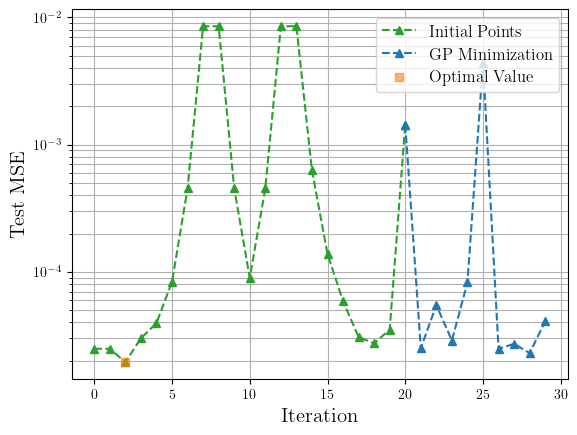

In [45]:
a = n_initial_points + len(x0)
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(func_iters.shape[0])

if a > 0:
    plt.semilogy(
        func_iters[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, func_iters.shape[0])
plt.semilogy(
    xplot,
    func_iters[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
plt.semilogy([optim_idx], [func_iters[optim_idx]], 's', alpha=0.6, label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Test MSE', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_aensb_plots+'/test_mse.pdf', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

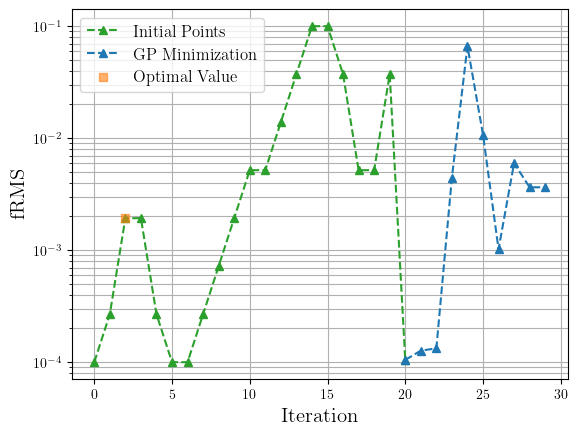

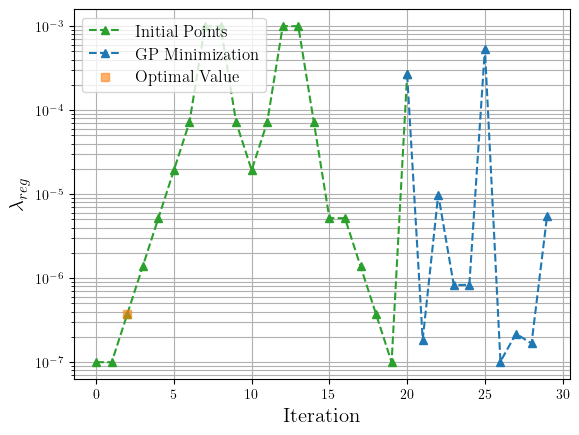

In [46]:
xoptim_names = [
    [r'fRMS', 'fRMS', plt.semilogy],
    [r'$\lambda_{reg}$', 'lambda_reg', plt.semilogy],
]

for i in range(len(xoptim_names)):
    a = n_initial_points + len(x0)
    # sorted_idx = np.argsort(x_iters[a:, 0])

    xplot = np.arange(x_iters.shape[0])
    if a > 0:
        xoptim_names[i][2](
            x_iters[:, i][0:a+1],
            linestyle='--',
            color='C2',
            marker='^',
            label='Initial Points',
        )
        xplot = np.arange(a, x_iters.shape[0])
    xoptim_names[i][2](
        xplot,
        x_iters[:, i][a:],
        linestyle='--',
        marker='^',
        label='GP Minimization',#'__nolegend__',
    )
    xoptim_names[i][2]([optim_idx], [x_iters[optim_idx, i]], 's', alpha=0.6, label='Optimal Value')

    plt.xlabel('Iteration', fontsize=15)
    plt.ylabel(xoptim_names[i][0], fontsize=15)
    plt.grid(True, which='major', axis='x')
    plt.grid(True, which='both', axis='y')
    plt.legend(fontsize=12)

    plt.savefig(dir_name_aensb_plots+'/'+xoptim_names[i][1]+'.pdf', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

In [47]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_ae_nsb+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_ae_nsb+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

In [48]:
# convergence plot
convergence_f = np.empty_like(func_iters)
min_val = np.inf
for i in range(func_iters.shape[0]):
    if func_iters[i] < min_val:
        min_val = func_iters[i]
    convergence_f[i] = min_val

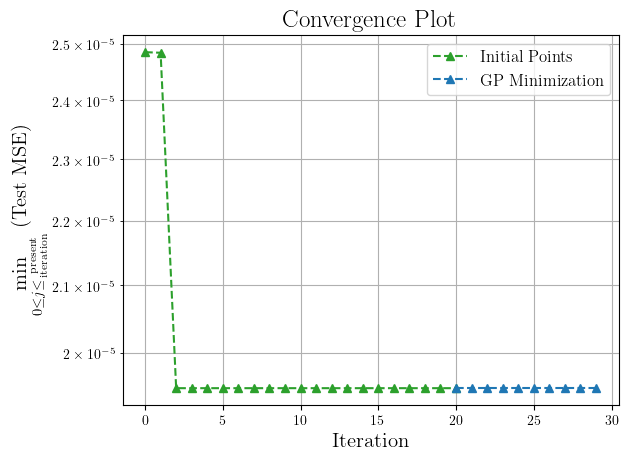

In [49]:
a = n_initial_points + len(x0)
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(x_iters.shape[0])

if a > 0:
    plt.semilogy(
        convergence_f[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, x_iters.shape[0])
plt.semilogy(
    xplot,
    convergence_f[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
# plt.semilogy([optim_idx], [func_iters[optim_idx, 0]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel(
#     r"$$\min_{0 \leq j \leq \mathrm{present \ iteration}} \left( \mathrm{Test \ MSE} \right)$$",
    r"$$\min_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Test \ MSE} \right)$$",
#     r"$$\max_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Median \ PH} \right)$$",
    fontsize=15,
)
plt.title('Convergence Plot', fontsize=18)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_aensb_plots+'/convergence_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

In [50]:
fRMS_sortidx = np.argsort(x_iters[:, 0])
lreg_sortidx = np.argsort(x_iters[:, 1])

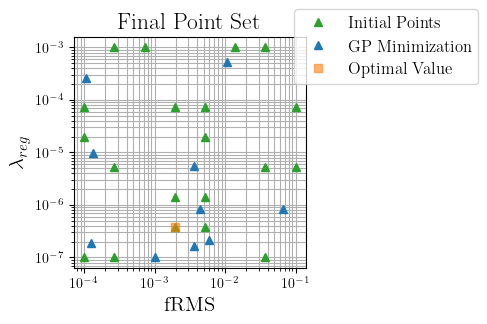

In [51]:
a = n_initial_points + len(x0)
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(x_iters.shape[0])
if a > 0:
    plt.loglog(
        x_iters[:, 0][0:a],
        x_iters[:, 1][0:a],
        linestyle='',
        color='C2',
        marker='^',
        label='Initial Points',
    )
#     xplot = np.arange(a, x_iters.shape[0])
plt.loglog(
    x_iters[:, 0][a:],
    x_iters[:, 1][a:],
    linestyle='',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)

plt.loglog(
    [x_iters[optim_idx, 0]],
    [x_iters[optim_idx, 1]],
    's',
    alpha=0.6,
    label='Optimal Value'
)

plt.gcf().legend(loc='upper right', bbox_to_anchor=(1.5,1), **legend_kwargs)
plt.xlabel(r'fRMS', fontsize=15)
plt.ylabel(r'$\lambda_{reg}$', fontsize=15)
plt.title(r'Final Point Set', fontsize=17)

plt.gcf().set_size_inches(3,3)

plt.grid(True, which='both')

plt.savefig(dir_name_aensb_plots+'/final_point_set.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# KE and Dissipation